In [113]:
import json
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tqdm import tqdm
#import japanize_matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
#from sciplotlib import style as spstyle
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedGroupKFold



def search_anatomy(modifiers,organ):
    ##anatomical_entity に指定の臓器が含まれているかを判別する。
    ##入力modifiers,organ(臓器の名前)   
    for i in range(len(modifiers)):
        modifier = modifiers[i]
        if organ in modifier['tokens'] and '副腎' not in modifier['tokens'] and modifier['type'] == 'Anatomical_entity':
            return True,modifier['tokens']
    return False,'not_found'
'''
def search_anatomy(modifiers,organ):
    ##anatomical_entity に指定の臓器が含まれているかを判別する。
    ##入力modifiers,organ(臓器の名前)   
    for i in range(len(modifiers)):
        modifier = modifiers[i]
        if organ in modifier['tokens'] and modifier['type'] == 'Anatomical_entity':
            return True
    return False
'''
def search_change(modifiers):
    ##change_descriptor　Chenge_discriptorが文中に含まれているかを判別
    ##入力　modifiers
    ##出力  含まれるかどうかbool,changeと判断されたwords(なければ0を入れる。)
    for i in range(len(modifiers)):
        modifier = modifiers[i]
        if modifier['type'] == 'Change_descriptor':
            return True,''.join(modifier['tokens'])
    return False,0

def search_clinicalfinding(modifiers):
    ##clinical_descriptor clinical_discriptorが文中に含まれているかを判別
    ##入力 modifiers
    ##出力  含まれるかどうかbool,clinicalと判断されたwords(なければ0を入れる。)
    for i in range(len(modifiers)):
        modifier = modifiers[i]
        if modifier['type'] == 'Clinical_finding':
            return modifier['certainty_score'],''.join(modifier['tokens'])
        else:continue
    return None,'not_found'

def search_imgobservation(sentence):
    ##clinical_descriptor clinical_discriptorが文中に含まれているかを判別
    ##入力 modifiers
    ##出力  含まれるかどうかbool,clinicalと判断されたwords(なければ0を入れる。)
    img_obs = sentence['clinical_object']
    if img_obs is not None:
        return img_obs['certainty_score'],img_obs['type'],''.join(img_obs['tokens'],)
    else:
        return None,'not_found'

def search_object(sentence,organ):
    ##構造化文章単位を入力として、特定臓器の情報が入っているかを調べる。
    ##入力 sentence
    ##出力  IO+AEのtoken,IO token,AE token,IOのcertainty_score,IOのtype
    img_obs = sentence['clinical_object']
    mdfs = sentence['modifiers']
    ae_tokens = []

    for i in range(len(mdfs)):
        mdf = mdfs[i]
        if mdf['type'] == 'Anatomical_entity':
            ae_tokens += mdf['tokens']
    
    keywords = ae_tokens+img_obs['tokens']
    #print(keywords)
    if organ in keywords:
        keywords = ''.join(ae_tokens+img_obs['tokens'])
        io_tokens = ''.join(img_obs['tokens'])
        ae_tokens = ''.join(ae_tokens)
        return keywords,io_tokens,ae_tokens,img_obs['certainty_score'],img_obs['type']
    else:
        return None,None,None,None,None

def to_multi_label(df,abnormal_list):
    for abnormal_label in abnormal_list+['nofinding']:
        df[abnormal_label] = df['label'].apply(lambda x: abnormal_label in x).astype(int)
    return df


In [114]:
###全体のラベル作成
###observationは絶対に文中にあるという前提。
###

df = pd.read_pickle('../server_data/all_data_20211001-20220605.zip')

organs = ['心','肝','胆','膵','脾','副腎','腎']
os.makedirs('../output',exist_ok=True)
counter = 0
jmid_names = df['jmid_name']
json_lists = df['FINDING_JSON']
#def detect_change(modifiers):
change_word_list = []
clinical_word_list = []
data = []
counter = 0
for jmid_name,json_load in zip(jmid_names,json_lists):
    for organ in organs:
        #print(organ)
        for i in range(len(json_load)):
            all_keyword,io_keyword,ae_keyword,certainty,img_type = search_object(json_load[i],organ)
            clinical_scale,clinical_word = search_clinicalfinding(json_load[i]['modifiers'])

            
            if all_keyword is not None:
                counter+=1
                data.append([jmid_name,organ,all_keyword,io_keyword,ae_keyword,certainty,img_type,clinical_word,clinical_scale])
            else:
                continue

data = pd.DataFrame(data,columns=['jmid_name','organ','all_tokens','io_tokens','ae_tokens','obs_certainty','obs_name','clin_findings','clin_certainty'])
data['jmid_name'] = data['jmid_name'].apply(lambda x:x.split('/')[-1])

## 腎のラベル作成

organs = ['腎']
os.makedirs('../output',exist_ok=True)
counter = 0
jmid_names = df['jmid_name']
json_lists = df['FINDING_JSON']
#def detect_change(modifiers):
change_word_list = []
clinical_word_list = []
data = []
for jmid_name,json_load in zip(jmid_names,json_lists):
    #json_open = open(json_list,'r')
    #key = os.path.basename(json_list).split('.')[0]
    #json_load = json.load(json_open)
    for organ in organs:
        #print(organ)
        for i in range(len(json_load)):
            bool_anatomy,token = search_anatomy(json_load[i]['modifiers'],organ)

            #bool_change,change = search_change(json_load[i]['modifiers'])
            #print(json_load[i]['modifiers'])
            clinical_scale,clinical_word = search_clinicalfinding(json_load[i]['modifiers'])
            observe_scale, observe_name, observe_word = search_imgobservation(json_load[i])
            
            if bool_anatomy:
                data.append([jmid_name,organ,''.join(token),observe_word,observe_name,observe_scale,clinical_word,clinical_scale])

            else:
                continue

data = pd.DataFrame(data,columns=['file','organ','token','obs_findings','obs_name','obs_certainty','clin_findings','clin_certainty'])
data['file'] = data['file'].apply(lambda x:x.split('/')[-1])

In [261]:
data_kidney = data[(data['obs_name'] == 'Imaging_observation') & (data['organ'] == '腎')].reset_index(drop=True)

In [262]:
print([i for i in data_kidney[data_kidney['obs_certainty'] == 0]['io_tokens'].value_counts().index])
normal_obs_finding_list = ['異常', '水腎', '所見', '異常所見', '腫瘤', '病変', '腎腫瘤', '有意な異常', '結石', '粗大病変', '事項', 'mass_lesion', '腎腫大', '狭窄', '水腎水尿管', '造影不領域', '腫瘤性病変', '腫大', '腎結石', '腫瘤影', '腫瘤形成', '腎腫瘍', '壁肥厚', '造影不良域', '造影不良', '拡張', 'SOL', '輪郭不整', '萎縮', '嚢胞', '腎嚢胞', '像', '脂肪成分', '脂肪濃度', '肥厚', '脂肪織濃度上昇', '腎排泄',  '血腫', '腎内腫瘤', '結節', '腎尿管結石', '造影低下', '腎腫瘤病変', '腎萎縮', '腎損傷', '腎増強不良域', '脂肪織の混濁', '実質腫瘤', '粗大腫瘤', '事項（-）', '有意な萎縮', '腎充実性腫瘤', '菲薄化', '濃度上昇', '出血性嚢胞', '毛羽立ち', '腫瘍', '瘤影', '充実性腫瘤', '拡張像', '充実腫瘤', '腎洞病変', '濃度上昇+結節', '異常ない異常', '水腎症', '腎機能低下', '異常像', 'mass', '変形', '腎盂', 'LDA', '石灰化', '結節病変', '腎病変', 'ただちに異常', '異常病変', '占拠性病変', '腎盂拡張', '出血', '脂肪織濃度の上昇', '線不透過性結石', '高濃度域', '造影欠損像', '器質的病変', '腎腫瘤形成', '腎SOL']

['異常', '水腎', '所見', 'リンパ節腫大', '異常所見', '腫瘤', '病変', '腎腫瘤', '有意な異常', '結石', '腫大リンパ節', '腹水', '粗大病変', '事項', 'mass_lesion', '腎腫大', '狭窄', '水腎水尿管', '造影不領域', '腫瘤性病変', '造影効果', '腫大', '腎結石', '腫瘤影', '腫瘤形成', '血栓形成', '腫瘍栓', '腎腫瘍', '副路発達水腎', '壁肥厚', '液貯留', '副腎腫瘤', '骨破壊像', '前立腺腫大', '造影不良域', '造影不良', '拡張', 'SOL', '輪郭不整', '萎縮', 'filling_defect', '腎動脈瘤', '嚢胞', '腎嚢胞', '像', 'beak_sign', '脂肪成分', '閉塞機転', '骨硬化性病変', '脂肪濃度', '肥厚', '尿排泄', '動脈瘤', '副腎腫大', '脂肪織濃度上昇', '腎排泄', '尿管結石', '有意なリンパ節', '副腎腫瘍', '尿管拡張', '血腫', '腎内腫瘤', '結節', '腎尿管結石', 'リンパ節', '造影低下', '腎腫瘤病変', '早期濃染', '腎萎縮', 'リンパ節腫脹', '腎損傷', '腎増強不良域', '脂肪織の混濁', '実質腫瘤', '粗大腫瘤', '解離', '事項（-）', '有意な萎縮', '異常壁肥厚像', '腎静脈腫瘍栓', '腎充実性腫瘤', '腹水貯留', '腹水の貯留', '菲薄化', '濃度上昇', '出血性嚢胞', '毛羽立ち', '腫瘍', '瘤影', '大半', '充実性腫瘤', '拡張像', '充実腫瘤', '腎洞病変', '濃度上昇+結節', '異常ない異常', '水腎症', '腫瘤（-）肝', '腎機能低下', '脂肪濃度上昇の進展', 'free_air', '水腎なし傍大動脈リンパ節腫大', '異常像', '尿路結石', '捻れ', 'mass', '肥大', '腸管壁肥厚', '動脈硬化', '変形', '腎動静脈瘻', '腎盂', '有意サイズ', '有意なサイズの腫脹', 'LDA', '石灰化', '結節病変', '腎病変', '構造', 'ただちに異常', '異常病変', '遅延', '胸

In [263]:
print([i for i in data_kidney[data_kidney['obs_certainty'] == 4]['io_tokens'].value_counts().index])
abnormal_obs_finding_list =['結石', '腎嚢胞', '嚢胞', '小嚢胞', '萎縮', '腫瘤', '変形', '石灰化', '拡張', '腫大', '結節',
                        '腎結石', '造影効果', '造影不良域', '早期濃染', '腎のう胞', '軟部影',  'complicated_cyst', 'サンゴ状石灰化', 
                        '腎盂嚢胞', 'LDA', '毛羽立ち', '腎萎縮', '微小嚢胞', '凍結域','傍腎盂のう胞','毛羽立ち', '脂肪織混濁','脂肪織濃度上昇', ]


#abnormal_obs_finding_list = [ '脾腫', '腫瘤影', '傍腎盂嚢胞', '濃染', '血腫', '脂肪腫', '腹部大動脈瘤', '嚢胞性病変', '腫瘤性病変', '血管筋脂肪腫', '脂肪濃度', 'シャント発達', '腎腫瘤', '壁在血栓', 'サンゴ状石灰化', '低濃度域', '水腎症', '大腸憩室', '傍腎盂のう胞', '狭小化', '肥厚', 'AML', '小石灰化', '腫大リンパ節', '前立腺腫大', '出血性嚢胞', '起始しています', 'air', 'wash_out', '瘤', 'リンパ節腫大', '萎縮瘢痕像', '出血性', '圧排', '毛羽立ち像', '血栓', '早期濃染像', '造影効果はまだら', '増強不良域', '脂肪濃度の結節', '軟部腫瘤', '構造', '分岐', '微小石灰化', '馬蹄腎', '造影効果低下', '脂肪肝', '胆石', '造影パターン', '造影不良', 'リピオドール残存', '瘢痕影', '造影効果低下域', '低吸収結節影', '腎盂拡張', '嚢胞性腫瘤', '造影効果が低下する領域', '低吸収部分', '複雑嚢胞', '混濁', '嚢胞腎', '軟部組織陰影', '高吸収嚢胞', '被包化液体貯留像', '軟部陰影', '腹膜／腹壁結節', '小腎嚢胞', '腹水貯留', '副路', '洗い出し', '造影不良なSOL', '開存', '脂肪織濃度の上昇', '嚢状動脈瘤', '遠肝性側副血行路発達', '分岐しています', '血栓化', '所見', '造影効果不良+液体貯留域', '大動脈瘤', '憩室', '隔壁', '食道静脈瘤', '腎瘢痕', '嚢状瘤', '小腫瘤', '腎シャント', '肝嚢胞', '静脈瘤', '脂肪性結節', '充実部', 'AAA', 'mass', 'カテーテル', '脂肪織濃度が上昇', '膀胱壁肥厚', 'サンゴ状結石', '脂肪織のけ', '腎動脈瘤', '腫瘤様病変', '脂肪濃度結節', '腹膜肥厚', '回転異常', '血流低下', '腎腫大', '脂肪性腫瘤', 'fluid', '紡錘状大動脈瘤', '拡大', '閉塞', '血管奇形', '膀胱結石', '胃静脈瘤', '壁石灰化', '口径不整', '尿管', 'ステント留置', '萎縮性変化', '高吸収結節', '低吸収', '充実性結節', '肝腫瘤', '瘢痕', '腹壁瘢痕ヘルニア', '結節性病変', '潰瘍形成（PAU', '瘢痕化', '水腎', '硬化性変化', '造影パタン', '結石ありあり', '瘢痕変形', '形成異常', 'Complicated_cyst', '腹膜結節', '脂肪濃度主体', '脂肪織混濁像', '腎嚢胞retroaortic_left_renal_vein', '軟部影内', '紡錘状瘤', '胃壁造影効果', '腫瘍', '嚢胞状構造', '造影域', '高濃度嚢胞', '動脈硬化性', '_left_renal_vein', '瘢痕萎縮', '嚢胞性陰影', '造影遅延', '索状影', '壁在結節', '狭窄部', 'シャントの発達', '尿管拡張', '造影剤の流出', '嚢胞壁', '造影剤', '陥凹', '高濃度結節', '梗塞像', '短絡', '増生', 'ガス像', '拡張像', '早期濃染し洗い出し', '重複尿管', 'Wash_out型', '紡錘状動脈瘤', '小病変', '大小嚢胞', '脂肪濃度混濁', '出血性嚢胞後の変化様の像', '造影欠損', '高吸収腫瘤', '造影効果が低下', '微小', '濃度上昇', '高濃度', '乳頭状腫瘍', '複雑性嚢胞', '腎血管筋脂肪腫', '壁構造', '高吸収化', '壁', '脂肪濃度上昇', '遅延', '嚢胞成分', '珊瑚状結石', '脂肪織の毛羽立ち', '萎縮像', 'IVC拡張', '腎サイズ', 'venous_sac', '染まり', '解離状構造', '髄質', '血栓化後', '高吸収な結節', '腫瘍栓', 'wash_out像', '瘤様拡張', '楔状増強不良域', '瘢痕状の変化', 'WON', '低吸収結節', '形態変化', '腹壁ヘルニア', '腎盂拡大', '造影効果は少し低下', '造影遅延域', '引き攣れ', '嚢胞変性', '胆嚢結石', '蛇行', '造影効果不良', '器質化', '脂肪織はけ', '造影低下域', '内部低吸収', '腸管拡張', '尿路', '思わす像', '拡張蛇行', '嚢早期濃染', '造影効果が不均一', '側副路発達', '異常', '肥大', '腫瘤像', 'ステント', '動脈硬化', '低吸収化', '分岐解離', '尿管ステント', 'S状結腸憩室', '造影効果やや不良', '毛羽立ち萎縮', '副脾', '所々増強不良域', 'IVCフィルター', '液面形成', '造影効果が遅延する領域', '嚢胞様', '副腎結節', '骨硬化', '骨折', '内部吸収値が低下', '圧排像', '上昇', 'ガス貯留', '腎実質', '膀胱憩室', '腫瘤形成', '被膜下血腫', '造影効果は不均一', '膀胱腫瘍', '口径不同', 'bridging_septaの肥厚', '腎瘻', 'クリップ', '脂肪織の濃度上昇', '血管影', '紡錘状拡張', '造影低下', '小動脈瘤', '小結節状構造', '膀胱壁', '骨盤内腫瘍', '癒着', '結石破砕後', '軟部組織像', '腸管壁肥厚', '結節状', '便', '高濃度域', '前立腺肥大', '小瘢痕', 'kinking', '食道裂孔ヘルニア', '腫瘤様構造', '粗大病変', '軟部濃度', '石灰化動脈瘤', '結石TUL後', '腎出血性嚢胞', '造影効果弱い', '腫瘍成分', '萎縮変形', '硬化像', 'FDG集積', '閉鎖リンパ節', '出血', '軟部濃度結節', '上極外側病変', '著明高吸収', '濃度低下', '十二指腸傍乳頭憩室', '膵嚢胞', '嚢状拡張', '突出像', '脂肪吸収値', '造影剤の残存', '髙吸収', '高吸収像', '金属濃度', '楔型状の低吸収域', '凍結領域', '増強効果は不均一', '腹水ごく', '傍ストーマヘルニア', '脂肪濃度腫瘤', '異常軟部組織', '嚢腫', '小のう胞', '腎実質菲薄化', '腫瘤状構造', '脂肪織毛羽立ち', '被包化壊死', '結節ないし隔壁', '萎縮様', 'petz', '脂肪の描出', '気腫', '部分萎縮', '内臓脂肪', 'HDA', '腎盂結石', '腎盂尿管拡張', '嚢胞様構造', '腫瘤状影', '高濃度なSOL', '高吸収の血性成分', '造影剤の残留', '脂肪性', '液体貯留域', 'あ理増す', '萎縮性', '造影剤排泄', '脂肪織', '結節状影', '造影', '腎実質萎縮', '高吸収物質', '脂肪濃度域', '子宮腫瘤', '高吸収なSOL', '尿管結石', '人工肛門', '粒状影', '線状異物', '薄い隔壁', '萎縮瘢痕', '高濃度含む嚢胞', '膨隆', 'complicate_cyst', '吸収値', '造影効果の低い領域', 'ち', '腎傍腔病変', '充実部分', '濃度', '腎腫瘍', '水腎の像', 'リピオドール集積', '索状陰影', '高吸収構造', 'シャント増生', '脂肪性の結節', '嚢胞性結節', '腎複雑性嚢胞', '腎委縮', '形態不整', '造影欠損像', '膜様構造', '軟部影増大', '杯結石', '軟部濃度構造', '高吸収の結節', '小結節影', '分枝', '造影能が低下', '肪織濃度上昇', '造影剤の排泄／残留', '右内鼠径ヘルニヤ', '側弯', '軟部濃度腫瘤', '移植腎', '脂肪織濃度', '萎縮or低形成', '子宮飲酒']

['腎嚢胞', '結石', '嚢胞', '小嚢胞', '萎縮', '腎萎縮', '腎結石', '腫瘤', '変形', '石灰化', '拡張', '腫大', '水腎', '結節', '小結石', 'シャント', '腎のう胞', '水腎症', '造影効果', '造影不良域', '早期濃染', '軟部影', '微小結石', 'complicated_cyst', '動脈瘤', '小結節', '腎腫大', 'LDA', '腎盂嚢胞', '毛羽立ち', '脂肪織混濁', '微小嚢胞', '凍結域', '脂肪織濃度上昇', '子宮筋腫', '病変', '馬蹄腎', 'リンパ節', '解離', '造影不領域', '像', '腎瘢痕', 'SOL', '高吸収', '腹水', '菲薄化', '移植腎', '瘤状拡張', '狭窄', '脂肪成分', '壁肥厚', '小リンパ節', '水腎水尿管', '腎動脈瘤', '筋腫', '腎腫瘤', '結節影', 'washout', '発達', '高吸収域', '結腸憩室', '液貯留', '液体貯留', '低吸収域', '脂肪', '脾腫', '腫瘤影', '傍腎盂嚢胞', '嚢胞腎', '血腫', '濃染', '脂肪腫', '腹部大動脈瘤', '嚢胞性病変', '脾腎シャント', '腫瘤性病変', '脂肪濃度', '血管筋脂肪腫', 'シャント発達', '低濃度域', '壁在血栓', '腎シャント', 'サンゴ状石灰化', 'AML', '肥厚', '狭小化', '傍腎盂のう胞', '大腸憩室', '小石灰化', '腫大リンパ節', '前立腺腫大', '出血性嚢胞', 'air', '起始しています', '萎縮瘢痕像', 'wash_out', 'リンパ節腫大', '瘤', '出血性', '腎部分萎縮', '毛羽立ち像', '圧排', '腎病変', '早期濃染像', '腎下部大動脈瘤', '造影効果はまだら', '増強不良域', '血栓', '脂肪濃度の結節', '軟部腫瘤', '腎高度萎縮', '微小石灰化', '分岐', '構造', '造影効果低下', '腎回転異常', '腎complicated_cyst', '脂肪肝', '造影不良', '造影パターン', '胆石', '腎盂拡張', 'リピオドール残存', '嚢胞性腫瘤', '腎

In [264]:
# img_paths = glob.glob('../data/lkidney_img/*.nii.gz') + glob.glob('../data/rkidney_img/*.nii.gz')
# os.makedirs('../data/kidney_img',exist_ok=True)

# for img_path in tqdm(img_paths):
#     signal = 'left' if img_path.split('/')[2] == 'lkidney_img' else 'right'
#     shutil.copyfile(img_path,'../data/kidney_img/'+os.path.basename(img_path)[:-7]+signal+'.nii.gz')

In [265]:
##まず、右左(両)の指定があればそれだけ取り出す。
##腎のみのtokenでも、certainty=0ならば両方負例として取り出す。
##todo:現在「腎」tokenは構造化不良により負例しか取り出していない。正例も取り出せるようにしたい。
print(data_kidney.shape)
normal_and_nonspecified_anatomy = (data_kidney['obs_certainty'] == 0)#data_kidney['ae_tokens'].apply(lambda x:x == '') & (data_kidney['obs_certainty'] == 0)
print('nonspecific',normal_and_nonspecified_anatomy.sum())
data_kidney['left'] = (data_kidney['all_tokens'].str.contains('左腎'))|(data_kidney['all_tokens'].str.contains('両腎'))|normal_and_nonspecified_anatomy
data_kidney['right'] = (data_kidney['all_tokens'].str.contains('右腎'))|(data_kidney['all_tokens'].str.contains('両腎'))|normal_and_nonspecified_anatomy
print(data_kidney['right'].sum(),data_kidney['left'].sum(),(data_kidney['left']*data_kidney['right']).sum())
## unpivot
data_kidney = pd.melt(data_kidney,id_vars=data_kidney.columns.values[:9],var_name='side',value_name='side_value').reset_index(drop=True)
data_kidney = data_kidney[data_kidney['side_value'] == True].reset_index(drop=True)
print(data_kidney.shape)


for i in tqdm(range(len(data_kidney))):
    data_kidney.loc[i,'jmid_name'] = data_kidney.loc[i,'jmid_name'].split('.')[0] + data_kidney.loc[i,'side'] +'.nii.gz'
print(data_kidney.shape)

available_segmentation_list = glob.glob('../data/kidney_img/*.nii.gz') 
available_segmentation_list = [os.path.basename(p) for p in available_segmentation_list]
use_segmentation = data_kidney['jmid_name'].apply(lambda x:x in available_segmentation_list)
print(data_kidney.shape)

use_normalfindings = data_kidney['io_tokens'].apply(lambda x:x in normal_obs_finding_list)
use_abnormalfindings = data_kidney['io_tokens'].apply(lambda x:x in abnormal_obs_finding_list)
#use_abnormalfindings = (data_kidney['clin_findings'].str.contains('癌') | data_kidney['clin_findings'].str.contains('IPMN'))
use_certainty = ((data_kidney['obs_certainty'] == 0) | (data_kidney['obs_certainty'] == 4) )
data_kidney['use_training'] = (use_normalfindings|use_abnormalfindings)& use_segmentation &use_certainty
data_kidney['abnormal'] = (data_kidney['obs_certainty']!=0)*(data_kidney['obs_certainty']*0.125+0.5)

##temporal
data_kidney['abnormal'] = (data_kidney.groupby("jmid_name").transform("max")["abnormal"]>0).astype(int)
data_kidney = data_kidney.drop_duplicates(subset='jmid_name')
#print(data_kidney.shape)

#data_kidney = data_kidney[((data_kidney['obs_certainty'] == 0) & (data_kidney['abnormal'] == 0))|((data_kidney['obs_certainty'] == 4) & (data_kidney['abnormal'] == 1))]
#data_kidney = data_kidney[(data_kidney['side_value'])|(data_kidney['obs_certainty'] == 0)]
print(data_kidney.shape,data_kidney['abnormal'].sum())
data_kidney_use = data_kidney[data_kidney['use_training'] == True].reset_index(drop=True)
data_kidney_use['file'] = data_kidney_use['jmid_name']
data_kidney_use['jmid_name'] = data_kidney_use['jmid_name'].apply(lambda x:'_'.join(x.split('_')[:-1])+'_0000.nii.gz')

print(data_kidney_use.shape)
data_kidney_use.drop_duplicates(inplace=True)
print(data_kidney_use.shape)
data_kidney_use = data_kidney_use.merge(df,on='jmid_name',how='left')
print(data_kidney_use.shape)


(41670, 9)
nonspecific 8498
27706 28899 20650


/home/jubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


(56605, 11)


100%|██████████| 56605/56605 [00:37<00:00, 1529.10it/s]


(56605, 11)
(56605, 11)
(43998, 13) 31498
(38841, 14)
(38841, 14)
(41847, 25)


In [266]:
groups = data_kidney_use['FACILITY_CODE'].astype(str)+data_kidney_use['ACCESSION_NUMBER'].astype(str)
cv = StratifiedGroupKFold(n_splits=20,shuffle=True,random_state=0)
for train_idxs, test_idxs in cv.split(np.arange(len(data_kidney_use)),data_kidney_use['abnormal']>0, groups):
    df_train= data_kidney_use.iloc[train_idxs]
    df_test = data_kidney_use.iloc[test_idxs]
    break

In [267]:
columns = ['file','organ','all_tokens','io_tokens','ae_tokens','obs_certainty','abnormal','FINDING','FINDING_JSON','FACILITY_CODE','ACCESSION_NUMBER']
df_train[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/kidney_dataset_train.csv',index=False)
df_test[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/kidney_dataset_test.csv',index=False)

In [215]:
data_df = df_train    
groups = data_df['FACILITY_CODE'].astype(str)+data_df['ACCESSION_NUMBER'].astype(str)
cv = StratifiedGroupKFold(n_splits=40,shuffle=True,random_state=0)

for train_idxs, test_idxs in cv.split(np.arange(len(data_df)),data_df['abnormal']>0, groups):
    tmp_train= data_df.iloc[train_idxs]
    tmp_test = data_df.iloc[test_idxs]
    break

## 肝のラベル作成

In [211]:
data_liver = data[(data['obs_name'] == 'Imaging_observation') & (data['organ'] == '肝')].reset_index(drop=True)

In [212]:
print([i for i in data_liver[data_liver['obs_certainty'] == 0]['io_tokens'].value_counts().index])

['SOL', '肝SOL', '異常', '所見', '病変', '腫瘤影', '肝腫瘤', '腫瘤', '脂肪肝', '腫瘤性病変', '肝内胆管拡張', '血栓', '肝脾腫', 'washout', '狭窄', '拡張', '腫瘍栓', '早期濃染', '像', '異常所見', '腫瘤形成', '染まり抜け', '占拠性病変', '有意な異常', '結節', 'wash_out', 'リンパ節腫大', '腫瘍', '洗い出し', '造影効果', '閉塞機転', '肝充実性腫瘤', 'LDA', '新出病変', '肝内SOL', '腫大', '肝腫大', '粗大病変', '血管腫', '液体貯留', '造影不良', '多血化', '肝病変', '腹水', '後期染まり抜け', '早期濃染像', '肝内結石', '早期濃染域', '拡張像', '造影不良域', '液貯留', '膿瘍', '早期濃染病変', '破格', '閉塞', '肝損傷', '内部壊死', '被包化', '粗大腫瘤', '濃染', '結石', '低吸収域', '拡大', '膜様構造', '顕在化', '副路発達', '開存', '脂肪濃度', '目立たず', '肝変形', '有意な肥厚', '古典的', 'anomaly', '点状早期濃染', '壁肥厚', '小LDA', '軟部影', '狭窄胆管拡張', '高吸収域', '肝膿瘍形成', '早期相濃染', '結節影', '異常濃染域', '浮腫', '凹凸不整', '肝内腫瘤性病変', '造影遅延', '前立腺腫大', 'encasement', '血流異常', '脈管侵襲', '総胆管拡張', '肝内病変', '肝内腫瘤', 'viableHCC', '肝嚢胞', 'biloma形成', '異常造影効果', '異常造影結節', '早期濃染不明瞭', '異常胆管拡張像', '造影ムラ', '結節状造影効果', 'washout像', '造影不領域', '早期造影', '腫瘍濃染像', '胆管拡張', 'extravasation', '膿瘍形成', '狭小化', '浸潤像', 'RFA後病変', '門脈腫瘍栓', '総肝管拡張', '肝占拠性病変', '異常濃度域', '小嚢胞', 'ヘルニア状突出', '低濃度域', '異常壁肥厚像', 

In [205]:
normal_obs_finding_list = ['SOL', '肝SOL', '異常', '所見', '病変', '腫瘤影', '肝腫瘤', '腫瘤', '脂肪肝', '肝内胆管拡張', '腫瘤性病変', 'washout', 
                        '早期濃染', '像', '異常所見', '腫瘤形成', '染まり抜け', '占拠性病変', '有意な異常', '結節', 'wash_out', '腫瘍', 
                        '洗い出し', '造影効果', '閉塞機転', '肝充実性腫瘤', 'LDA', '新出病変', '肝内SOL', '肝腫大', '腫大', '粗大病変', '造影不良', '血管腫', '液体貯留', 
                        '肝病変', '拡張像', '早期濃染域', '早期濃染像', '後期染まり抜け', '肝内結石', '造影不良域', '液貯留', '早期濃染病変', '膿瘍', '破格', '結石', '粗大腫瘤', 
                        '濃染', '肝損傷', '閉塞', '被包化', '内部壊死', '拡大', '低吸収域', '肝変形', '膜様構造', '有意な肥厚', '顕在化', '目立たず', '開存', '脂肪濃度', '副路発達', '軟部影', 
                        '小LDA', 'anomaly', '点状早期濃染', '高吸収域', '古典的', '壁肥厚', '浮腫', '凹凸不整', '結節影', '異常濃染域', '早期相濃染', '肝内腫瘤性病変', 
                        '造影遅延', '肝膿瘍形成', '血流異常', '肝内病変', '腫瘍濃染像', 'biloma形成', '狭小化', '膿瘍形成', 
                        '異常造影結節', 'viableHCC', 'RFA後病変', '浸潤像', '結節状造影効果', '肝内腫瘤', '早期濃染不明瞭', '早期造影', '造影不領域', '異常造影効果', 'washout像', 
                        '肝嚢胞', '肝占拠性病変', '早期濃染まり', '小嚢胞', '異常壁肥厚像', '異常濃度域', '肝LDA', '低濃度域','早期濃染の所見', 
                        '低吸収結節', '骨病変肝脾腫', '小結節', '事項', '肝脾腫大', '肝内胆管拡張像', '膿瘍腔', '斑状早期濃染', '造影効果低下域', 'ただちに異常', 
                        '肝内LDA', '嚢胞構造', 'うっ血肝', '石灰化', '肝内結石の新出', '異常ない異常', 'mass', '浮腫性変化', '肝実質低吸収域', 
                        '嚢胞状病変', '脂肪肝の新出', '嚢胞性病変']

In [206]:
print([i for i in data_liver[data_liver['obs_certainty'] != 0]['io_tokens'].value_counts().index])

['肝嚢胞', '脂肪肝', '嚢胞', '拡張', '小嚢胞', '早期濃染', '開存', '肝内胆管拡張', '腫瘤', 'LDA', '血管腫', '早期濃染域', '造影効果', '結節', '軟部影', 'リンパ節', '液貯留', 'SOL', '低吸収域', 'リンパ節腫大', '狭小化', '肝のう胞', '腹水', '液体貯留', '肝血管腫', '早期濃染結節', '病変', '石灰化', '微小嚢胞', '腫大', '早期濃染像', '狭窄', 'pneumobilia', '造影不良域', '低吸収', '肝腫大', '濃染', '小結節', '胆管拡張', '低濃度域', '壁肥厚', '乏血性結節', '小リンパ節', '血腫', '変形', '早期造影域', '肝石灰化', 'RFA後変化', '小肝嚢胞', '血流', '肝腫瘤', '肝変形', '萎縮', 'washout', '肝縁鈍化', '腫大リンパ節', '低吸収結節', '肝形態', 'wash_out', '腫瘤影', '微小肝嚢胞', '小石灰化', '腎嚢胞', '閉塞', '低濃度', '結節状早期濃染', '拡張像', '分岐しています', '高吸収域', '発達', '造影不良', '胆石', '高吸収', '嚢胞性病変', '肝SOL', '脾腫', '結節状の早期濃染', '腫瘍栓', '像', '腫瘍', '腫瘤性病変', '軟部濃度', '結節状', '肝萎縮', 'AP_shunt', '変形萎縮', '遠肝性側副路発達', 'PV_shunt', '濃染域', '顕在化', '解離', '凹凸不整', '蛇行', '結節影', '浮腫', '被包化液貯留', '肝硬変', 'air', '造影域', '小血管腫', '軟部組織陰影', '濃染結節', '腹水貯留', '肝内胆管拡張像', '脂肪化', '鈍化', '軟部濃度域', '圧排', '肝内石灰化', '脂肪織混濁', '小早期濃染像', '軟部組織', '肝内外胆管拡張', 'PVシャント', '早期増強効果', 'P-Vシャント', '軟部陰影', '造影結節', '総胆管拡張', '濃度上昇', '脂肪沈着', '肝脾腫', '造影効果は不均一', '肝内結石', '肝病変', '

In [207]:


abnormal_obs_finding_list = ['肝嚢胞', '脂肪肝', '嚢胞', '拡張', '小嚢胞', '早期濃染', '開存', '肝内胆管拡張', '腫瘤', 'LDA', '血管腫', '早期濃染域', '造影効果', '結節', '軟部影', 'リンパ節', '液貯留', 'SOL', '低吸収域', '狭小化', 'リンパ節腫大', '肝のう胞', '腹水', '液体貯留', '早期濃染結節', '肝血管腫', '病変', '石灰化', '微小嚢胞', '腫大', '早期濃染像', '狭窄', 'pneumobilia', '造影不良域', '低吸収', '肝腫大', '濃染', '小結節', '胆管拡張', '壁肥厚', '低濃度域', '乏血性結節', '小リンパ節', '血腫', '変形', '早期造影域', '肝石灰化', 'RFA後変化', '小肝嚢胞', '血流', '肝腫瘤', '肝変形', '萎縮', 'washout', '肝縁鈍化', '腫大リンパ節', '肝形態', '低吸収結節', 'wash_out', '腫瘤影', '小石灰化', '微小肝嚢胞', '腎嚢胞', '閉塞', '低濃度', '結節状早期濃染', '分岐しています', '拡張像', '高吸収域', '発達', '高吸収', '胆石', '造影不良', '嚢胞性病変', '腫瘍栓', '結節状の早期濃染', '像', '脾腫', '肝SOL', '腫瘍', '結節状', 'AP_shunt', '腫瘤性病変', '軟部濃度', '肝萎縮', '変形萎縮', '遠肝性側副路発達', 'PV_shunt', '濃染域', '解離', '顕在化', '凹凸不整', '蛇行', '結節影', '浮腫', '被包化液貯留', '肝硬変', 'air', '造影域', '小血管腫', '濃染結節', '軟部組織陰影', '腹水貯留', '肝内胆管拡張像', '脂肪織混濁', '小早期濃染像', '肝内石灰化', '軟部濃度域', '圧排', '鈍化', '脂肪化', '早期増強効果', '軟部組織', '肝内外胆管拡張', '軟部陰影', 'PVシャント', 'P-Vシャント', '肝脾腫', '造影結節', '造影効果は不均一', '脂肪沈着', '濃度上昇', '総胆管拡張', 'グラフト', '肝病変', '染まり抜け', 'free_air', '肝内結石', '動脈瘤', '被包化', '早期造影効果', '腫瘤形成', 'normal_size_and_shape', '増強効果', '造影不領域', '求肝性', '血栓', 'LDAs', '造影効果まだら', '造影効果乏しく', '肝内胆管拡張軽減', 'ステントの開存性', '小突出', '遠肝性側副血行路', 'ドレーンチューブ', '血流異常', '分岐', '血性腹水', '浮腫性変化', '肝内胆管気腫', '結石', '遠肝性側副血行路発達', '肝内病変', '突出像', '増強不良域', '小LDA', '陥凹', '肝結節', '肝膿瘍', '微小結節', 'HCCs', '分岐するパターン', '小早期濃染', 'カテーテル留置', '後期染まり抜け', '所見', '副路発達', '遠肝性', '異常造影効果', 'Air', '低吸収化', '濃度', '造影ムラ', '乏血性病変', '焼灼域', '造影', '胸水（-）肝', 'リピオドール集積', '嚢胞性陰影', '小結節状領域', '肝外胆管拡張', '嚢胞変性', '肝吸収値', '遠肝性側', '早期濃染し後期洗い出し', '口径不整', '発達像', '結節状の濃染', '微小石灰化', '濃染像', '造影パターン', '造影効果低下', '造影効果がまだら', '脂肪濃度', 'cavity', '脂肪性結節', '遠肝性側副路', '造影効果は低下', '貯留', '軟部濃度組織', '肥厚部', 'コイル', '集積', '肥厚', '結節状構造', '結腸憩室', '被包化液体貯留', '突出', '腹水増加', '早期濃染領域', '造影効果良好', '線状の造影欠損領域', '壁肥厚像', 'cavernous_transformation', '静脈拡張', '辺縁鈍化', '乏血性', '造影遅延', '遠肝性側副血行路形成', '狭細化', '脂肪腫', '高濃度', '破格（-）胆石', '液体', '大部分脂肪濃度', '脈管開存', '胆道気腫', '領域', 'lipiodol沈着', 'spared_lesion', '壊死状', '肝内胆管拡張±胆', '広狭不整', '萎縮変形', '静脈内腫瘍栓', 'densityの低下', '吸収値高く', '遊離ガス', '小濃染域', '乏血性な領域', '後期相染まり抜け', '門脈瘤', '早期', 'lipiodol沈着部', '造影効果の残る領域', 'ドレーン', '浮腫状壁肥厚', '鋭', '静脈早期還流', '造影剤の流入', '軟部組織濃度', '血管筋脂肪腫', '遠肝性側副血行の発達', 'enhanced_nodule', '門脈開存', 'fill-in', '胆管チューブ', '胆嚢腫大', '高濃度域', '凹凸', '起始', '壊死変性', 'ステント', '濃染パターン', '胆嚢床', '地図状脂肪肝', '軽度胆管拡張', '胸水', '脂肪濃度結節', '造影増強効果', '液貯留腔', '脂肪織の毛羽立ち', '胆管tube', 'walled-off_necrosis', '腹膜肥厚', '共通幹', 'リンパ節腫大（-）肝', '低信号域', 'CCC', '早期濃染腫瘤', '早期造影結節', '軽度肝内胆管拡張', '肝嚢胞不変', 'A-P_shunt', '細化', '金属マーカー', '低濃度病変', '主膵管拡張', 'たわみ', '腫瘍血管の発達', '外側域', '治療瘢痕', '末梢胆管拡張', '嚢胞状の腔', '吸収値', '脂肪濃度の結節', 'density', 'Lpd集積', 'ENBD_tube', '膿瘍', '肝低濃度結節', '大腸憩室', '肝形態変化', '肝内胆管狭窄', 'リピオドール貯留', '造影腫瘤', '病変内', '高吸収な液貯留', '門脈ガス', '嚢状瘤', '構造', '早期還流', '造影欠損', '肝下面膿瘍', '濃染域の広がり', 'washoutする領域', '早期濃染-wash_out', '斑状早期濃染', '早期分岐', '鈍化変形', '求肝性側副路発達', '肝内動脈血流', 'AP-shunt', '造影早期', 'APシャント', '造影効果はまだら', '脂肪肝の像', '染まり方', '肝門部胆管病変', '脂肪変性像', '辺縁', '胃静脈瘤肝', '口径', '微小結節状の早期濃染', 'リピオドール沈着', '増強域', '脂肪肝高度', '脂肪濃度混濁', '血管腫様', '造影後早期', '仮性動脈瘤', '胆管気腫像', '乏血性の結節', 'pseudocirrhosis', '像（-）肝', '狭窄部', '結節様', '肝部分', '低濃度結節', '胆管拡張（-）地図状脂肪肝', '遠肝性側副路増生', '地図状濃染', '側副路発達', '小病変', '造影効果不良', 'cTACE後', '緊満感', 'くびれ', '造影効果不良域', '造影病変', '焼灼域内', '索状影', '肝囊胞', '非脂肪沈着', '嚢胞ないし血管腫', 'encasement', '菲薄化', '胆管腫瘍栓', 'wash_out域', '沿う淡い染まり', 'スパズム様変化', '気腫', 'ring_enhancement', '壁', '淡く早期濃染後', '肥大', '早期濃染／washout', '梗塞像', '共通管', '脂肪結節', '拡張軽減', '狭窄像', '小石灰化像', '結節状早期濃染域', '早期濃染濃染域', 'たり', '内部濃染増強', '腫瘤影（-）胆管拡張', '充実部分', '瘤状拡張', '腹壁肥厚', 'グリソン浮腫', '結節状早期濃染病変', '液体貯留像', 'ステント留置', '脂肪肝（-）', '濃度は不均一', '照射域', 'PTCD_tube', 'Lip貯留', '肝LDA', '不染域', '肝内コントラスト不良', 'dull', '血行動態', 'びPneumobilia', '後期洗い出し', '肝辺縁鈍化', '早期描出', '肝損傷', '肝門部胆管壁肥厚', '肉芽腫', '瘤', '細径化', '洗い出し', '嚢胞様腫瘤', '液', 'cavity残存', 'ガス貯留', '濃染する領域', '代償性発達', 'Wash_out', '造影遅延域', '隔壁構造', 'RFA変化', 'lipiodol', '描出不良', '軽度肝内胆管拡張像', '早期濃染する領域', 'FDG集積', '瘤状の拡張', '肝門部リンパ節腫大', '結節状病変', '総肝', '早期濃染腫瘤影', '異常集積', '小結節状の早期濃染域', '濃染し洗い出し', 'つながるair', '肝硬変の像', 'encase', '早期濃染部位', '濃染部', 'RFA後瘢痕', '嚢胞状拡張', '濃度低下', '肝グリソン浮腫', '陰影', '造影効果が低下', '肝LDAs', '枝状air', '早期造影不領域', '脂肪肝破壊前', '造影効果は均一', '病変小さく', '肝早期濃染像', '胆管気腫', '早期相にて濃染', '胆管ステント', '外側区域低吸収域', 'うっ血肝', 'pneumobiliawp', '早期濃染病変', '早期造影病変', '巨大肝嚢胞', '造影剤', '高吸収結節', 'P-V_shunt', '結節構造', '脂肪', '吸収域', '膿瘍腔', '小SOL', '巨大嚢胞', '巨大腫瘤', '粗大病変', 'Lipiodol集積', '輝度上昇', '血管腫病変', '胸水（-）肝血管腫', '形態変化', '小増強', '肝内低濃度域', '結節性過形成', 'アーチファクト', '小低吸収域', '肝縁の鈍化', 'リピオドール', '低吸収病変', 'cavemous_transformation', '小結節影', '内部densityは低下', 'Lipiodol貯留', '結節性病変', '濃度も不均一', 'peripheral_globular_enhancement',  '微小低吸収域', '結節状集積', '浮腫像', '嚢胞状の構造', 'SOL様', '索状LDA', '沈着','低吸収な領域', '浮腫状肥厚', '圧迫', '高集積', '脂肪濃度腫瘤', '濃度が上昇', '小葉肝隔壁の肥厚', '空洞', '変性', '軽度肝', '肝内低吸収域', '前方への突出', '出血', '低吸収なSOL', '肝機能低下', '嚢補', 'shunt', '陥凹（scalloping）', '心拡大（-）肝嚢胞', '低吸結節', '異物', '小サイズのLDA', '総胆管結石ERCP後肝内胆管拡張', '高吸収菜帯状', '肝内低濃度結節', '主病変', 'AML', '点状石灰化像', '脂肪織の濃度上昇', '低吸収の陰影', '上昇', '肝periportal_collar', '取り込み低下結節', 'pseudolipoma', '軟部組織の増大', '低濃度SOL', 'リング状濃染域', '肝低吸収域', 'ガス像', '内部吸収値が上昇', '造影剤貯留', '濃度改善', '脂肪肝改善', '脂肪性腫瘤', '肝点状石灰化', 'peumobilia', '低吸収SOL', 'ENBD', '内外瘻後脂肪肝', '異常濃度域', '瘢痕像', '肝門部液貯留', '微小石灰', 'debris', '胆管内気腫', '石灰化病変', '肝実質高吸収', '表面凹凸', '肝内SOL', '脂肪成分', '肝表不整', '対称肝', '索状の低吸収域', '濃度は均一', 'ガス', '吸収値上昇', '粗大石灰化', '肝内胆管拡張残存']

abnormal_obs_finding_list = ['肝嚢胞', '脂肪肝', '嚢胞', '拡張', '小嚢胞', '早期濃染', '肝内胆管拡張', '腫瘤', 'LDA', '血管腫', '早期濃染域', '造影効果', '結節', '軟部影', '液貯留', 'SOL', '低吸収域',
                        '肝のう胞', '液体貯留', '肝血管腫', '早期濃染結節', '病変', '石灰化', '微小嚢胞', '腫大', '早期濃染像', '狭窄', 'pneumobilia', '造影不良域', '低吸収', '肝腫大', '濃染', '小結節',
                        '胆管拡張', '低濃度域', '乏血性結節','変形', '早期造影域', '肝石灰化', 'RFA後変化', '小肝嚢胞',  '肝腫瘤', '肝変形', '萎縮', 'washout', '肝縁鈍化', '低吸収結節', '肝形態', 'wash_out',
                        '腫瘤影', '微小肝嚢胞', '小石灰化', '低濃度', '結節状早期濃染', '拡張像', '高吸収域', '造影不良', '高吸収', '嚢胞性病変', '肝SOL', '結節状の早期濃染', '腫瘍', '腫瘤性病変', '軟部濃度',
                        '結節状', '肝萎縮']
abnormal_obs_finding_list = ['肝嚢胞', '脂肪肝', '嚢胞', '拡張', '小嚢胞', '早期濃染', '開存', '肝内胆管拡張', '腫瘤', 'LDA', '血管腫', '早期濃染域', '造影効果', '結節', '軟部影',
                            'リンパ節', '液貯留', 'SOL', '低吸収域', '狭小化', 'リンパ節腫大', '肝のう胞', '腹水', '液体貯留', '早期濃染結節', '肝血管腫', '病変', '石灰化', '微小嚢胞', 
                            '腫大', '早期濃染像', '狭窄', 'pneumobilia', '造影不良域', '低吸収', '肝腫大', '濃染', '小結節', '胆管拡張', '壁肥厚', '低濃度域', '乏血性結節', '小リンパ節', 
                            '血腫', '変形', '早期造影域', '肝石灰化', 'RFA後変化', '小肝嚢胞', '血流', '肝腫瘤', '肝変形', '萎縮', 'washout', '肝縁鈍化', '腫大リンパ節', '肝形態', '低吸収結節', 
                            'wash_out', '腫瘤影', '小石灰化', '微小肝嚢胞', '腎嚢胞', '閉塞', '低濃度', '結節状早期濃染', '分岐しています', '拡張像', '高吸収域', '発達', '高吸収', '胆石', '造影不良', 
                            '嚢胞性病変', '腫瘍栓', '結節状の早期濃染', '像', '脾腫', '肝SOL', '腫瘍', '結節状', 'AP_shunt', '腫瘤性病変']
###normal findingsの所見idは0として、abnobal findingsの所見idをカテゴリごとに割り振る(i.e. 嚢胞→１、石灰化→2,脂肪肝→3などなど)
### マルチラベルにする。
##正常として使うラベルを指定する。
#normal_obs_finding_list = ['SOL', '異常', '所見', '病変', '腫瘤影', '腫瘤', '腫瘤性病変','異常所見','占拠性病変', '有意な異常','新出病変','washout']
##異常として使うラベルを指定する。
#abnormal_obs_finding_list = ['嚢胞', '拡張', '小嚢胞', '腫瘤', 'LDA', '血管腫', '脂肪肝', '石灰化','肝嚢胞', '早期濃染像', 'pneumobilia']
##疾患のグループにまとめる。
abnormal_obs_finding_id = [0,1,0,2,0,8,2,3,3,4,8,8,3,8,8,3,3,0,8,4,3,8,6,0,8,3,8,7,3,3,5,8,3,2,3,3,5,3,6,8,0,3,5,5,3,5,3,5,3,3,0,6,3,3,2,3,3,3,0,3,3,3,3,8,3,5]
abnormal_obs_finding_id = [0,1,0,2,0,4,2,3,3,4,4,4,3,4,4,3,3,0,4,4,3,4,4,0,4,3,4,4,3,3,4,4,3,2,3,3,4,3,4,4,0,3,4,4,3,4,3,4,3,3,0,4,3,3,2,3,3,3,0,3,3,3,3,4,3,4]

abnormal_obs_finding_id = [0,1,0]+[2]*80
##グループのまとまりの名前をつける。まとまりごとに文字の包含関係がないようにする。→嚢胞と肝嚢胞というグループを作らない。
abnormal_obs_finding_list_renamed = ['嚢胞', '脂肪肝', '胆管拡張', 'SOL',  '血管腫', '変形', '石灰化','pneumobilia','other_abnormality']
abnormal_obs_finding_list_renamed = ['嚢胞', '脂肪肝', 'other_abnormality']


In [218]:
use_normalfindings = (data_liver['io_tokens'].apply(lambda x:x in normal_obs_finding_list)) & (data_liver['obs_certainty'] == 0)
use_abnormalfindings = (data_liver['io_tokens'].apply(lambda x:x in abnormal_obs_finding_list)) & (data_liver['obs_certainty'] != 0)
available_segmentation_list = glob.glob('../data/liver_seg_img/*.nii.gz') 
available_segmentation_list = [os.path.basename(p) for p in available_segmentation_list]
use_segmentation = data_liver['jmid_name'].apply(lambda x:x in available_segmentation_list)
# use_abnormalfindings = (data_liver['clin_findings'].str.contains('癌') | data_liver['clin_findings'].str.contains('IPMN'))
# use_certainty = ((data_liver['obs_certainty'] == 0) | (data_liver['obs_certainty'] == 4) )
data_liver['use_training'] = (use_normalfindings|use_abnormalfindings) & use_segmentation 
data_liver['label'] = 'not used'
data_liver.loc[use_abnormalfindings,'label'] = data_liver.loc[use_abnormalfindings,'io_tokens'].apply(lambda x:abnormal_obs_finding_list_renamed[abnormal_obs_finding_id[abnormal_obs_finding_list.index(x)]])
data_liver.loc[use_normalfindings,'label'] = 'nofinding'
tmp = data_liver.groupby('jmid_name')['label'].apply(lambda x: x.tolist())
data_liver.drop('label',axis=1,inplace=True)
data_liver = data_liver.merge(tmp,how='left',on='jmid_name')

#data_liver = data_liver[data_liver['use_training'] == True].reset_index(drop=True)


In [219]:
data_liver = to_multi_label(data_liver,abnormal_obs_finding_list_renamed)

data_liver = data_liver.drop_duplicates(subset='jmid_name')
print(data_liver.shape)
data_liver_use = data_liver[data_liver['use_training'] == True].reset_index(drop=True)
data_liver_use['file'] = data_liver_use['jmid_name']
data_liver_use['jmid_name'] = data_liver_use['jmid_name'].apply(lambda x:'_'.join(x.split('_')[:-1])+'_0000.nii.gz')

print(data_liver_use.shape)
#data_liver_use.drop_duplicates(inplace=True)
print(data_liver_use.shape)
data_liver_use = data_liver_use.merge(df,on='jmid_name',how='left').drop_duplicates(subset='jmid_name')
print(data_liver_use.shape)

(31238, 15)
(28291, 16)
(28291, 16)
(28291, 27)


In [220]:
data_liver_use[abnormal_obs_finding_list_renamed+['nofinding']].sum(axis=0)

嚢胞                   10644
脂肪肝                   3955
other_abnormality    10193
nofinding             9288
dtype: int64

In [189]:
## cleanなラベルは削除する。
clean_df = pd.read_csv('../data/liver_dataset_test_clean.csv')
jmid_files_clean = clean_df['file'].values
tmp = data_liver_use[data_liver_use['jmid_name'].apply(lambda x:x in jmid_files_clean)]
test_groups = tmp['FACILITY_CODE'].astype(str)+tmp['ACCESSION_NUMBER'].astype(str)
groups = data_liver_use['FACILITY_CODE'].astype(str)+data_liver_use['ACCESSION_NUMBER'].astype(str)


df_train = data_liver_use[groups.apply(lambda x:x not in test_groups.tolist())]
df_test =  data_liver_use[groups.apply(lambda x:x in test_groups.tolist())]

# cv = StratifiedGroupKFold(n_splits=60,shuffle=True,random_state=0)
# for train_idxs, test_idxs in cv.split(np.arange(len(data_liver_use)),data_liver_use['nofinding']>0, groups):
#     df_train= data_liver_use.iloc[train_idxs]
#     df_test = data_liver_use.iloc[test_idxs]
#     break

columns = ['file','organ','all_tokens','io_tokens','ae_tokens','obs_certainty','FINDING','FINDING_JSON','FACILITY_CODE','ACCESSION_NUMBER','nofinding']+abnormal_obs_finding_list_renamed
df_train[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/liver_dataset_train_multi.csv',index=False)
df_test[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/liver_dataset_test_multi.csv',index=False)

In [176]:
data_df = df_test   
groups = data_df['FACILITY_CODE'].astype(str)+data_df['ACCESSION_NUMBER'].astype(str)
len(groups.unique())

216

In [202]:
df_train['nofinding'].sum()

9144

## 膵のラベル作成

In [297]:
data_pancreas = data[(data['obs_name'] == 'Imaging_observation') & (data['organ'] == '膵')].reset_index(drop=True)
print(data_pancreas['obs_certainty'].value_counts(),data_pancreas.shape)

0    14189
4    13967
2       80
3       40
1       20
Name: obs_certainty, dtype: int64 (28296, 9)


In [298]:
print([i for i in data_pancreas[data_pancreas['obs_certainty'] == 0]['io_tokens'].value_counts().index])

['異常', '主膵管拡張', '所見', '異常所見', '拡張', '腫瘤', '膵腫瘤', '膵腫大', 'SOL', '腫大', 'mass_lesion', '有意な異常', '膵管拡張', '腫瘤形成', '腫瘤性病変', '病変', '充実成分', 'リンパ節腫大', '充実部分', '閉塞機転', '嚢胞性病変', '粗大病変', '造影不良域', '異常拡張像', '早期濃染', '事項', '腫瘤影', '膵SOL', '液貯留', '嚢胞', '充実部', '造影効果', '膵石', '造影不領域', '腹水', '主膵管拡張像', '壁在結節', '占拠性病変', '萎縮', '乏血性領域', '結節', '胆道気腫', '脂肪織濃度上昇', '膵腫瘤形成', '膵液瘻', '狭窄', '膵胆管合流異常', '軟部影', '被膜様構造', '膵嚢胞性病変', 'air', '脾腫', '狭窄機転', '造影不良', '早期濃染腫瘤', '充実性腫瘍', '壁肥厚', '胆管拡張', '膵内SOL', '浸潤像', '腫瘍発生', '充実性成分', '結節性病変', '結節状濃染', '膵管癒合不全', '増強不良域', '隆起性病変', '膵石灰化', '異常濃度域', '早期濃染病変', '充実性部分', 'mass_leison', '像', '尿管結石', '凹凸', '閉塞', '脈管変形', '有意な拡張', '増強不良', '液体貯留腔', '新出病変', '事項（-）', 'LDA', '結節影', '粗大腫瘤', 'mass形成', '液貯留像', '異常壁肥厚像', '動脈瘤', '濃度上昇', '水腎', '口径不整', '脂肪織混濁', 'せず', '異常病変', '骨破壊像', '膵充実性腫瘤', '膵腫瘍', '前立腺腫大', '髙吸収の物質', '濃度上昇域', 'FDG集積', '膵萎縮', '腫大リンパ節', '造影', '所見傍大動脈リンパ節腫大', 'cavity', '小結石', 'Lip貯留', '形態的異常', '混濁', 'ただちに異常', 'ドレーン']


In [299]:
normal_obs_finding_list = ['異常', '所見', '異常所見', '拡張', '腫瘤', '主膵管拡張', 'SOL', '腫大', 'mass_lesion', '有意な異常', '腫瘤形成',
                         '腫瘤性病変', '病変', '充実成分', '充実部分', '閉塞機転', '粗大病変', '嚢胞性病変', '造影不良域', '異常拡張像', '早期濃染',
                         '事項', '腫瘤影', '液貯留', '嚢胞', '造影効果', '造影不領域','壁在結節', '膵腫大', '占拠性病変', '萎縮', '乏血性領域', 
                         '結節', '脂肪織濃度上昇', '狭窄', '被膜様構造', '軟部影', '狭窄機転', '早期濃染腫瘤', '充実性腫瘍', '膵SOL', '造影不良', 
                         '浸潤像', '壁肥厚', '主膵管拡張像', 'mass_leison', '液体貯留腔', '閉塞', '充実性成分', '腫瘍発生', '充実性部分', '異常濃度域', 
                         '隆起性病変', '膵管拡張', '早期濃染病変', '結節性病変', '脈管変形', '結節状濃染', '有意な拡張', '新出病変', 'LDA', '粗大腫瘤', 
                         '事項（-）', '異常壁肥厚像', '口径不整', 'mass形成', '濃度上昇', '結節影', '異常病変', '脂肪織混濁', '形態的異常']
normal_obs_finding_list = ['異常', '主膵管拡張', '所見', '異常所見', '拡張', '腫瘤', '膵腫瘤', '膵腫大', 'SOL', '腫大', 'mass_lesion', '有意な異常', '膵管拡張', '腫瘤形成', '腫瘤性病変', '病変', '充実成分', 'リンパ節腫大', '充実部分', '閉塞機転', '嚢胞性病変', '粗大病変', '造影不良域', '異常拡張像', '早期濃染', '事項', '腫瘤影', '膵SOL', '液貯留', '嚢胞', '充実部', '造影効果', '膵石', '造影不領域', '腹水', '主膵管拡張像', '壁在結節', '占拠性病変', '萎縮', '乏血性領域', '結節', '胆道気腫', '脂肪織濃度上昇', '膵腫瘤形成', '膵液瘻', '狭窄', '膵胆管合流異常', '軟部影', '被膜様構造', '膵嚢胞性病変', 'air', '脾腫', '狭窄機転', '造影不良', '早期濃染腫瘤', '充実性腫瘍', '壁肥厚', '胆管拡張', '膵内SOL', '浸潤像', '腫瘍発生', '充実性成分', '結節性病変', '結節状濃染', '膵管癒合不全', '増強不良域', '隆起性病変', '膵石灰化', '異常濃度域', '早期濃染病変', '充実性部分', 'mass_leison', '像', '尿管結石', '凹凸', '閉塞', '脈管変形', '有意な拡張', '増強不良', '液体貯留腔', '新出病変', '事項（-）', 'LDA', '結節影', '粗大腫瘤', 'mass形成', '液貯留像', '異常壁肥厚像', '動脈瘤', '濃度上昇', '水腎', '口径不整', '脂肪織混濁', 'せず', '異常病変', '骨破壊像', '膵充実性腫瘤', '膵腫瘍', '前立腺腫大', '髙吸収の物質', '濃度上昇域', 'FDG集積', '膵萎縮', '腫大リンパ節', '造影', '所見傍大動脈リンパ節腫大', 'cavity', '小結石', 'Lip貯留', '形態的異常', '混濁', 'ただちに異常', 'ドレーン']

In [301]:
print([i for i in data_pancreas[data_pancreas['obs_certainty'] != 0]['io_tokens'].value_counts().index])

['嚢胞性病変', '主膵管拡張', '拡張', '腫瘤', '嚢胞', '小嚢胞', '萎縮', '腫大', '副脾', '石灰化', '腎嚢胞', '膵石', '低吸収域', '結節', '脾腫', '液貯留', '軟部影', '膵嚢胞性病変', '小嚢胞性病変', '膵萎縮', '液体貯留', 'LDA', '造影効果', '病変', '腫瘍', '膵腫大', '腫瘤影', 'リンパ節腫大', '膵管拡張', '脂肪織混濁', '小石灰化', '早期濃染', '膵嚢胞', 'リンパ節', '傍十二指腸乳頭憩室', '像', '嚢胞性腫瘤', '早期濃染結節', '脂肪織濃度上昇', '造影不良域', '結石', '高吸収', '脂肪腫', '拡張像', '小リンパ節', '脂肪膵', '異常', '発達', '膵石灰化', 'SOL', '低吸収', '結節影', '主膵管拡張像', '狭小化', 'air', '早期濃染域', '濃染', '微小嚢胞', '傍乳頭憩室', '被包化液貯留', '脂肪置換', '毛羽立ち', '膵液瘻', '腫瘤性病変', '造影不良', '造影不領域', '嚢胞病変', '肥大', '嚢胞構造', '被包化', '狭窄', '造影域', '脂肪沈着', '軟部陰影', '結腸憩室', '脈管構造', '腹水貯留', '小結節', '充実成分', '腫大リンパ節', '乏血性腫瘍', '肥厚', '枝膵管拡張', '脂肪織濃度の上昇', '脾動脈瘤', '変形', '濃度上昇', 'mass', '子宮筋腫', '結節状', '毛羽立ち像', '脂肪変性', 'ステント', '膵アーケード発達', '高吸収な構造', '膵腫瘤', '壁肥厚', '造影パターン', '結節様構造', '膵管チューブ', '血管腫', '低形成', '集積', '低濃度域', '脂肪濃度の結節', '軟部濃度組織', '混濁', '軟部組織陰影', '低吸収な領域', '囊胞性病変', '囊胞構造', '嚢胞様構造', '輪状膵', '嚢胞壁', '腫大して', '造影結節', '充実部', '小低吸収域', '造影効果不良', '脂肪壊死', '異常拡張像', '液体貯留像', 'tube', '脂肪濃度', '膵管ステント', '石灰化病変'

In [302]:
#abnormal_obs_finding_list = ['異常', '主膵管拡張', '所見', '異常所見', '拡張', '腫瘤', '膵腫瘤', '膵腫大', 'SOL', '腫大', 'mass_lesion', '膵管拡張', '有意な異常', '腫瘤形成', '腫瘤性病変', '病変', '充実成分', 'リンパ節腫大', '嚢胞性病変', '充実部分', '閉塞機転', '粗大病変', '異常拡張像', '造影不良域', '早期濃染', '嚢胞', '事項', '液貯留', '腫瘤影', '膵SOL', '充実部', '膵液瘻', '造影効果', '膵石', '脈管構造', '造影不領域', '腹水', '壁在結節', '主膵管拡張像', '占拠性病変', '萎縮', '結節', '乏血性領域', '血管腫', '脂肪織濃度上昇', '胆道気腫', '膵腫瘤形成', '狭窄', '膵胆管合流異常', '軟部影', '被膜様構造', '膵嚢胞性病変', '像', 'walled-off_necrosis', '脾腫', 'air', '被包化壊死', '狭窄機転', '膵内SOL', '造影不良', '浸潤像', '膵嚢胞', '枝膵管拡張', '早期濃染腫瘤', '胆管拡張', '壁肥厚', '充実性腫瘍', '脂肪腫', '動脈瘤', '増強不良', '膵管癒合不全', '結節状濃染', '膵嚢胞内', '腫瘍発生', '充実性成分', '隆起性病変', '増強不良域', '早期濃染病変', '脈管変形', 'mass_leison', '尿管結石', '膵石灰化', '結節性病変', '液体貯留腔', '閉塞', '凹凸', '充実性部分', '異常濃度域', '有意な拡張', '結節構造', '異常壁肥厚像', '水腎', '新出病変', '事項（-）', 'LDA', '粗大腫瘤', '結節影', '口径不整', '濃度上昇', 'mass形成', '液貯留像', '液体貯留', '血腫', '脂肪織混濁', '骨破壊像', '低形成', '異常病変', 'せず', '結石', '結節様構造', '髙吸収の物質', '濃度上昇域', '形態的異常', '膵充実性腫瘤', 'cavity', '腫大リンパ節', '膵萎縮', '小嚢胞', '所見傍大動脈リンパ節腫大', 'FDG集積', 'Lip貯留', '膵腫瘍', '膵頭部嚢胞', '混濁', '陳旧化', '小嚢胞性病変', 'ただちに異常', '血栓化', 'ドレーン', '小結石', '前立腺腫大', '造影']
                            
abnormal_obs_finding_list = ['嚢胞性病変', '主膵管拡張', '拡張', '腫瘤', '嚢胞', '小嚢胞', '萎縮', '腫大', '石灰化', '膵石', '低吸収域', '結節', '液貯留', '軟部影', '膵嚢胞性病変', '小嚢胞性病変', '膵萎縮', '液体貯留', 'LDA', '造影効果', '病変', '腫瘍', '膵腫大', '腫瘤影', '膵管拡張', '小石灰化', '早期濃染', '膵嚢胞', '像', '嚢胞性腫瘤', '早期濃染結節', '脂肪織濃度上昇', '造影不良域', '結石', '高吸収', '脂肪腫', '拡張像', '小リンパ節', '脂肪膵', '異常', '発達', '膵石灰化', 'SOL', '低吸収', '結節影']

In [303]:
available_segmentation_list = glob.glob('../data/pancreas_img/*.nii.gz') 
available_segmentation_list = [os.path.basename(p) for p in available_segmentation_list]
use_segmentation = data_pancreas['jmid_name'].apply(lambda x:x in available_segmentation_list)
print(data_pancreas.shape)

use_normalfindings = data_pancreas['io_tokens'].apply(lambda x:x in normal_obs_finding_list)
use_abnormalfindings = data_pancreas['io_tokens'].apply(lambda x:x in abnormal_obs_finding_list)
#use_abnormalfindings = (data_pancreas['clin_findings'].str.contains('癌') | data_pancreas['clin_findings'].str.contains('IPMN'))
use_certainty = ((data_pancreas['obs_certainty'] == 0) | (data_pancreas['obs_certainty'] == 4) )
data_pancreas['use_training'] = (use_normalfindings|use_abnormalfindings)& use_segmentation &use_certainty
data_pancreas['abnormal'] = (data_pancreas['obs_certainty']!=0)*(data_pancreas['obs_certainty']*0.125+0.5)

##temporal
data_pancreas['abnormal'] = (data_pancreas.groupby("jmid_name").transform("max")["abnormal"]>0).astype(int)
data_pancreas = data_pancreas.drop_duplicates(subset='jmid_name')
#print(data_pancreas.shape)

#data_pancreas = data_pancreas[((data_pancreas['obs_certainty'] == 0) & (data_pancreas['abnormal'] == 0))|((data_pancreas['obs_certainty'] == 4) & (data_pancreas['abnormal'] == 1))]
#data_pancreas = data_pancreas[(data_pancreas['side_value'])|(data_pancreas['obs_certainty'] == 0)]
print(data_pancreas.shape,data_pancreas['abnormal'].sum())
data_pancreas_use = data_pancreas[data_pancreas['use_training'] == True].reset_index(drop=True)
data_pancreas_use['file'] = data_pancreas_use['jmid_name']
data_pancreas_use['jmid_name'] = data_pancreas_use['jmid_name'].apply(lambda x:'_'.join(x.split('_')[:-1])+'_0000.nii.gz')

print(data_pancreas_use.shape)
data_pancreas_use.drop_duplicates(inplace=True)
print(data_pancreas_use.shape)
data_pancreas_use = data_pancreas_use.merge(df,on='jmid_name',how='left').drop_duplicates(subset='jmid_name')
print(data_pancreas_use.shape)

(28296, 9)
(19167, 11) 9760
(17077, 12)
(17077, 12)
(17077, 23)


In [304]:
groups = data_pancreas_use['FACILITY_CODE'].astype(str)+data_pancreas_use['ACCESSION_NUMBER'].astype(str)
cv = StratifiedGroupKFold(n_splits=40,shuffle=True,random_state=0)
for train_idxs, test_idxs in cv.split(np.arange(len(data_pancreas_use)),data_pancreas_use['abnormal']>0, groups):
    df_train= data_pancreas_use.iloc[train_idxs]
    df_test = data_pancreas_use.iloc[test_idxs]
    break

columns = ['file','organ','all_tokens','io_tokens','ae_tokens','obs_certainty','abnormal','FINDING','FINDING_JSON','FACILITY_CODE','ACCESSION_NUMBER']
df_train[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/pancreas_dataset_train.csv',index=False)
df_test[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/pancreas_dataset_test.csv',index=False)

In [21]:
df[df['jmid_name'] == 'jmid_0032502_0000.nii.gz']['FINDING'].values

array(['2021年02月24日のCTと対比しました。膵は分葉構造が軽度不明瞭化・軽度腫大あり前回とほぼ同様です。慢性的に炎症を繰り返しているようです。頭体部に限局して造影効果不良と軽度の実質萎縮が見られます。膵管癒合不全（以前のERPで交通見られ不完全型s/o）ありSantorini管は最大径7mmと拡張しています（Santorini管は窓形成様；キー画像1）。2020/9/7CTでは一旦改善していたものが再増悪しています。副乳頭部に閉塞機転が疑われますが明らかな腫瘤形成は指摘できません。内視鏡所見とも御対比ください。現時点では膵石なし乳頭部近傍には小石灰化散見しますが、Wirsung管の拡張はわずかで閉塞機転になっていないようです。膵周囲のリンパ節に軽度腫大散見します。反応性腫大s/o炎症反復によるものか、膵頭部の細かな動脈アーケードおよび門脈の側副路が軽度発達しています。CA根部狭窄は見られません。軽度脂肪肝あり。LHAから副LGA分岐あり胆嚢結石あり。胆嚢体部、底部に壁肥厚像を認め、胆嚢腺筋腫症を疑います。その他の腹部臓器に特記所見なし。腹水なし。有意なサイズのリンパ節腫大なし。 '],
      dtype=object)

## 脾臓

In [315]:
data_spleen = data[(data['obs_name'] == 'Imaging_observation') & (data['organ'] == '脾')].reset_index(drop=True)
print(data_spleen['obs_certainty'].value_counts(),data_spleen.shape)

0    9913
4    8521
2      50
3       5
1       3
Name: obs_certainty, dtype: int64 (18492, 9)


In [316]:
print([i for i in data_spleen[data_spleen['obs_certainty'] == 0]['io_tokens'].value_counts().index])

['異常', '所見', '異常所見', '脾腫', '有意な異常', '肝脾腫', 'リンパ節腫大', '病変', '粗大病変', '腫大', '事項', '血栓', '腹水', '腫大リンパ節', '口径不整', '狭窄', '高度肝脾腫', 'SOL', '脾腫大', '脾腫瘤', '造影不領域', '副血行路発達像', '閉塞', '仮性動脈瘤', '骨破壊像', '前立腺腫大', '水腎', '腫瘤', '脾損傷', '粗大腫瘤', '尿管結石', '広狭不整', '腫瘤性病変', '処置', '瘤', '主膵管拡張', 'LDA', '事項（-）', '異常壁肥厚像', '嚢状瘤', '胆管拡張', '結節', '血腫', '閉塞機転', '新出病変', '肝脾腫大', '骨病変肝脾腫', '腹水貯留', '異常病変', '造影剤の流入', '濃度上昇', '壁肥厚', '脂肪織濃度上昇', '異常ない異常', '像', '低吸収域', '腫瘤影', '造影増強効果']


In [317]:
normal_obs_finding_list = ['異常', '所見', '異常所見', '脾腫', '有意な異常', '肝脾腫', 'リンパ節腫大', '病変', '粗大病変', '腫大', '事項', '血栓', '腹水',  '口径不整', '狭窄', '高度肝脾腫', 'SOL', '脾腫大', '脾腫瘤', '造影不領域', '腫瘤', '脾損傷', '粗大腫瘤', '広狭不整', '腫瘤性病変', '処置', 'LDA', '事項（-）', '異常壁肥厚像', '結節', '血腫', '閉塞機転', '新出病変', '肝脾腫大', '骨病変肝脾腫', '異常病変', '造影剤の流入', '濃度上昇', '壁肥厚', '脂肪織濃度上昇', '異常ない異常', '像', '低吸収域', '腫瘤影', '造影増強効果']

In [318]:
print([i for i in data_spleen[data_spleen['obs_certainty'] != 0]['io_tokens'].value_counts().index])

['脾腫', '副脾', '腎嚢胞', '腫大', '脾動脈瘤', 'LDA', '腫瘤', 'シャント', '嚢胞', '閉塞', '小嚢胞', '拡張', '石灰化', '低吸収域', '胆石', '狭窄', '血栓', '動脈瘤', '嚢胞性病変', '腹水', '結石', '腎盂嚢胞', '変形', '結節', '発達', '脾腫大', '軟部影', '異常', '狭小化', '脾嚢胞', 'SOL', '萎縮', '壁肥厚', '小結節', '腫瘤影', '腎のう胞', '子宮筋腫', '脾腎シャント', '副血行路発達像', '腎萎縮', '蛇行', 'リンパ節腫大', 'シャント発達', '脾結節', '腎結石', '瘤状拡張', '肥厚', '肝脾腫', '造影不領域', '脾LDA', '瘤', '液貯留', '結腸憩室', '脾腫瘤', '小結石', '血管腫', '脾嚢胞性病変', '石灰化脾動脈瘤', '腫瘤内部', '脾腫瘍', '小石灰化', '傍腎盂嚢胞', '構造', 'encasement', 'air', 'くびれ', '血栓化', '収縮状態', '血腫瘤', '脾石灰化', '起始しています', '造影不良域', '低濃度域', '液体貯留', '造影効果', '小腎嚢胞', '造影不良', '口径', '腎シャント', '水腎症', '低吸収結節', '血流', '腫瘍', '血流低下', '脾腫同様', '緊満', '嚢胞性腫瘤', '腹膜肥厚', '気腫', '馬蹄腎', 'リンパ節', '小LDA', '胃壁造影効果', '小低吸収域', '微小嚢胞', '梗塞', '門脈瘤', '側副路発達', '脂肪織の介在', '腎嚢胞retroaortic_left_renal_vein', '多脾症', '腹部大動脈瘤', '造影不良SOL', '食道裂孔ヘルニア', '短絡', '腎短絡', '側副路', '造影欠損域', '瘤形成', '接触', '分岐', 'シャントの発達', '索状影', '解離', '結節性病変', '嚢状動脈瘤', '索状LDA', '増生', '部分梗塞', '静脈瘤', '血性閉塞', '脾動脈拡張', '早期濃染結節', '濃度上昇', '線状', '血栓閉塞', '前立腺腫大', '硬化

In [319]:
abnormal_obs_finding_list = ['脾腫', '副脾',  '腫大', 'LDA', '腫瘤', '嚢胞', '小嚢胞', '拡張', '石灰化', '低吸収域', '狭窄', '動脈瘤', '嚢胞性病変', '結石', '変形', '結節', '発達', '脾腫大', '軟部影', '異常', '狭小化', '脾嚢胞', 'SOL', '萎縮', '壁肥厚', '小結節', '腫瘤影', '脾結節', '肥厚', '肝脾腫', '造影不領域', '脾LDA', '液貯留',  '脾腫瘤', '小結石', '血管腫', '脾嚢胞性病変','腫瘤内部', '脾腫瘍', '小石灰化']

In [320]:
available_segmentation_list = glob.glob('../data/spleen_seg_img/*.nii.gz') 
available_segmentation_list = [os.path.basename(p) for p in available_segmentation_list]
use_segmentation = data_spleen['jmid_name'].apply(lambda x:x in available_segmentation_list)
print(data_spleen.shape)

use_normalfindings = data_spleen['io_tokens'].apply(lambda x:x in normal_obs_finding_list)
use_abnormalfindings = data_spleen['io_tokens'].apply(lambda x:x in abnormal_obs_finding_list)
#use_abnormalfindings = (data_spleen['clin_findings'].str.contains('癌') | data_spleen['clin_findings'].str.contains('IPMN'))
use_certainty = ((data_spleen['obs_certainty'] == 0) | (data_spleen['obs_certainty'] == 4) )
data_spleen['use_training'] = (use_normalfindings|use_abnormalfindings)& use_segmentation &use_certainty
data_spleen['abnormal'] = (data_spleen['obs_certainty']!=0)*(data_spleen['obs_certainty']*0.125+0.5)

##temporal
data_spleen['abnormal'] = (data_spleen.groupby("jmid_name").transform("max")["abnormal"]>0).astype(int)
data_spleen = data_spleen.drop_duplicates(subset='jmid_name')
#print(data_spleen.shape)

#data_spleen = data_spleen[((data_spleen['obs_certainty'] == 0) & (data_spleen['abnormal'] == 0))|((data_spleen['obs_certainty'] == 4) & (data_spleen['abnormal'] == 1))]
#data_spleen = data_spleen[(data_spleen['side_value'])|(data_spleen['obs_certainty'] == 0)]
print(data_spleen.shape,data_spleen['abnormal'].sum())
data_spleen_use = data_spleen[data_spleen['use_training'] == True].reset_index(drop=True)
data_spleen_use['file'] = data_spleen_use['jmid_name']
data_spleen_use['jmid_name'] = data_spleen_use['jmid_name'].apply(lambda x:'_'.join(x.split('_')[:-1])+'_0000.nii.gz')

print(data_spleen_use.shape)
data_spleen_use.drop_duplicates(inplace=True)
print(data_spleen_use.shape)
data_spleen_use = data_spleen_use.merge(df,on='jmid_name',how='left').drop_duplicates(subset='jmid_name')
print(data_spleen_use.shape)

(18492, 9)
(16031, 11) 7108
(13450, 12)
(13450, 12)
(13450, 23)


In [340]:
groups = data_spleen_use['FACILITY_CODE'].astype(str)+data_spleen_use['ACCESSION_NUMBER'].astype(str)
cv = StratifiedGroupKFold(n_splits=30,shuffle=True,random_state=0)
for train_idxs, test_idxs in cv.split(np.arange(len(data_spleen_use)),data_spleen_use['abnormal']>0, groups):
    df_train= data_spleen_use.iloc[train_idxs]
    df_test = data_spleen_use.iloc[test_idxs]
    break

columns = ['file','organ','all_tokens','io_tokens','ae_tokens','obs_certainty','abnormal','FINDING','FINDING_JSON','FACILITY_CODE','ACCESSION_NUMBER']
df_train[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/spleen_dataset_train.csv',index=False)
df_test[columns].sort_values(by='file').reset_index(drop=True).to_csv('../data/spleen_dataset_test.csv',index=False)

## 腎臓

In [126]:
data_kidney = data[(data['obs_name'] == 'Imaging_observation') & (data['organ'] == '腎')].reset_index(drop=True)

In [127]:
data_kidney

,file,organ,obs_findings,obs_name,obs_certainty,clin_findings,clin_certainty


In [210]:
df[df['jmid_name'] == 'jmid_00000008_0000.nii.gz']['FINDING'].values

array([], dtype=object)

In [143]:
df[df['jmid_name'] == 'jmid_0021505_0000.nii.gz']['FINDING_JSON'].values

array([list([{'clinical_object': {'type': 'Imaging_observation', 'tokens': ['SOL'], 'surface': None, 'start_idx': 2, 'end_idx': 2, 'sui': None, 'certainty_level': 'denial', 'certainty_score': 0}, 'modifiers': [{'type': 'Anatomical_entity', 'tokens': ['肝'], 'surface': None, 'start_idx': 0, 'end_idx': 0, 'sui': None, 'certainty_level': None, 'certainty_score': None}]}, {'clinical_object': {'type': 'Clinical_finding', 'tokens': ['胆', '管', '合流', '異常', '症'], 'surface': None, 'start_idx': 48, 'end_idx': 52, 'sui': None, 'certainty_level': 'definitive', 'certainty_score': 4}, 'modifiers': [{'type': 'Anatomical_entity', 'tokens': ['主', '膵', '管'], 'surface': None, 'start_idx': 16, 'end_idx': 18, 'sui': None, 'certainty_level': None, 'certainty_score': None}, {'type': 'Anatomical_entity', 'tokens': ['総', '胆', '管'], 'surface': None, 'start_idx': 20, 'end_idx': 22, 'sui': None, 'certainty_level': None, 'certainty_score': None}, {'type': 'Anatomical_entity', 'tokens': ['共通', '管'], 'surface': None, 

# 以下、EDA

Text(0.5, 1.0, '臓器別所見数')

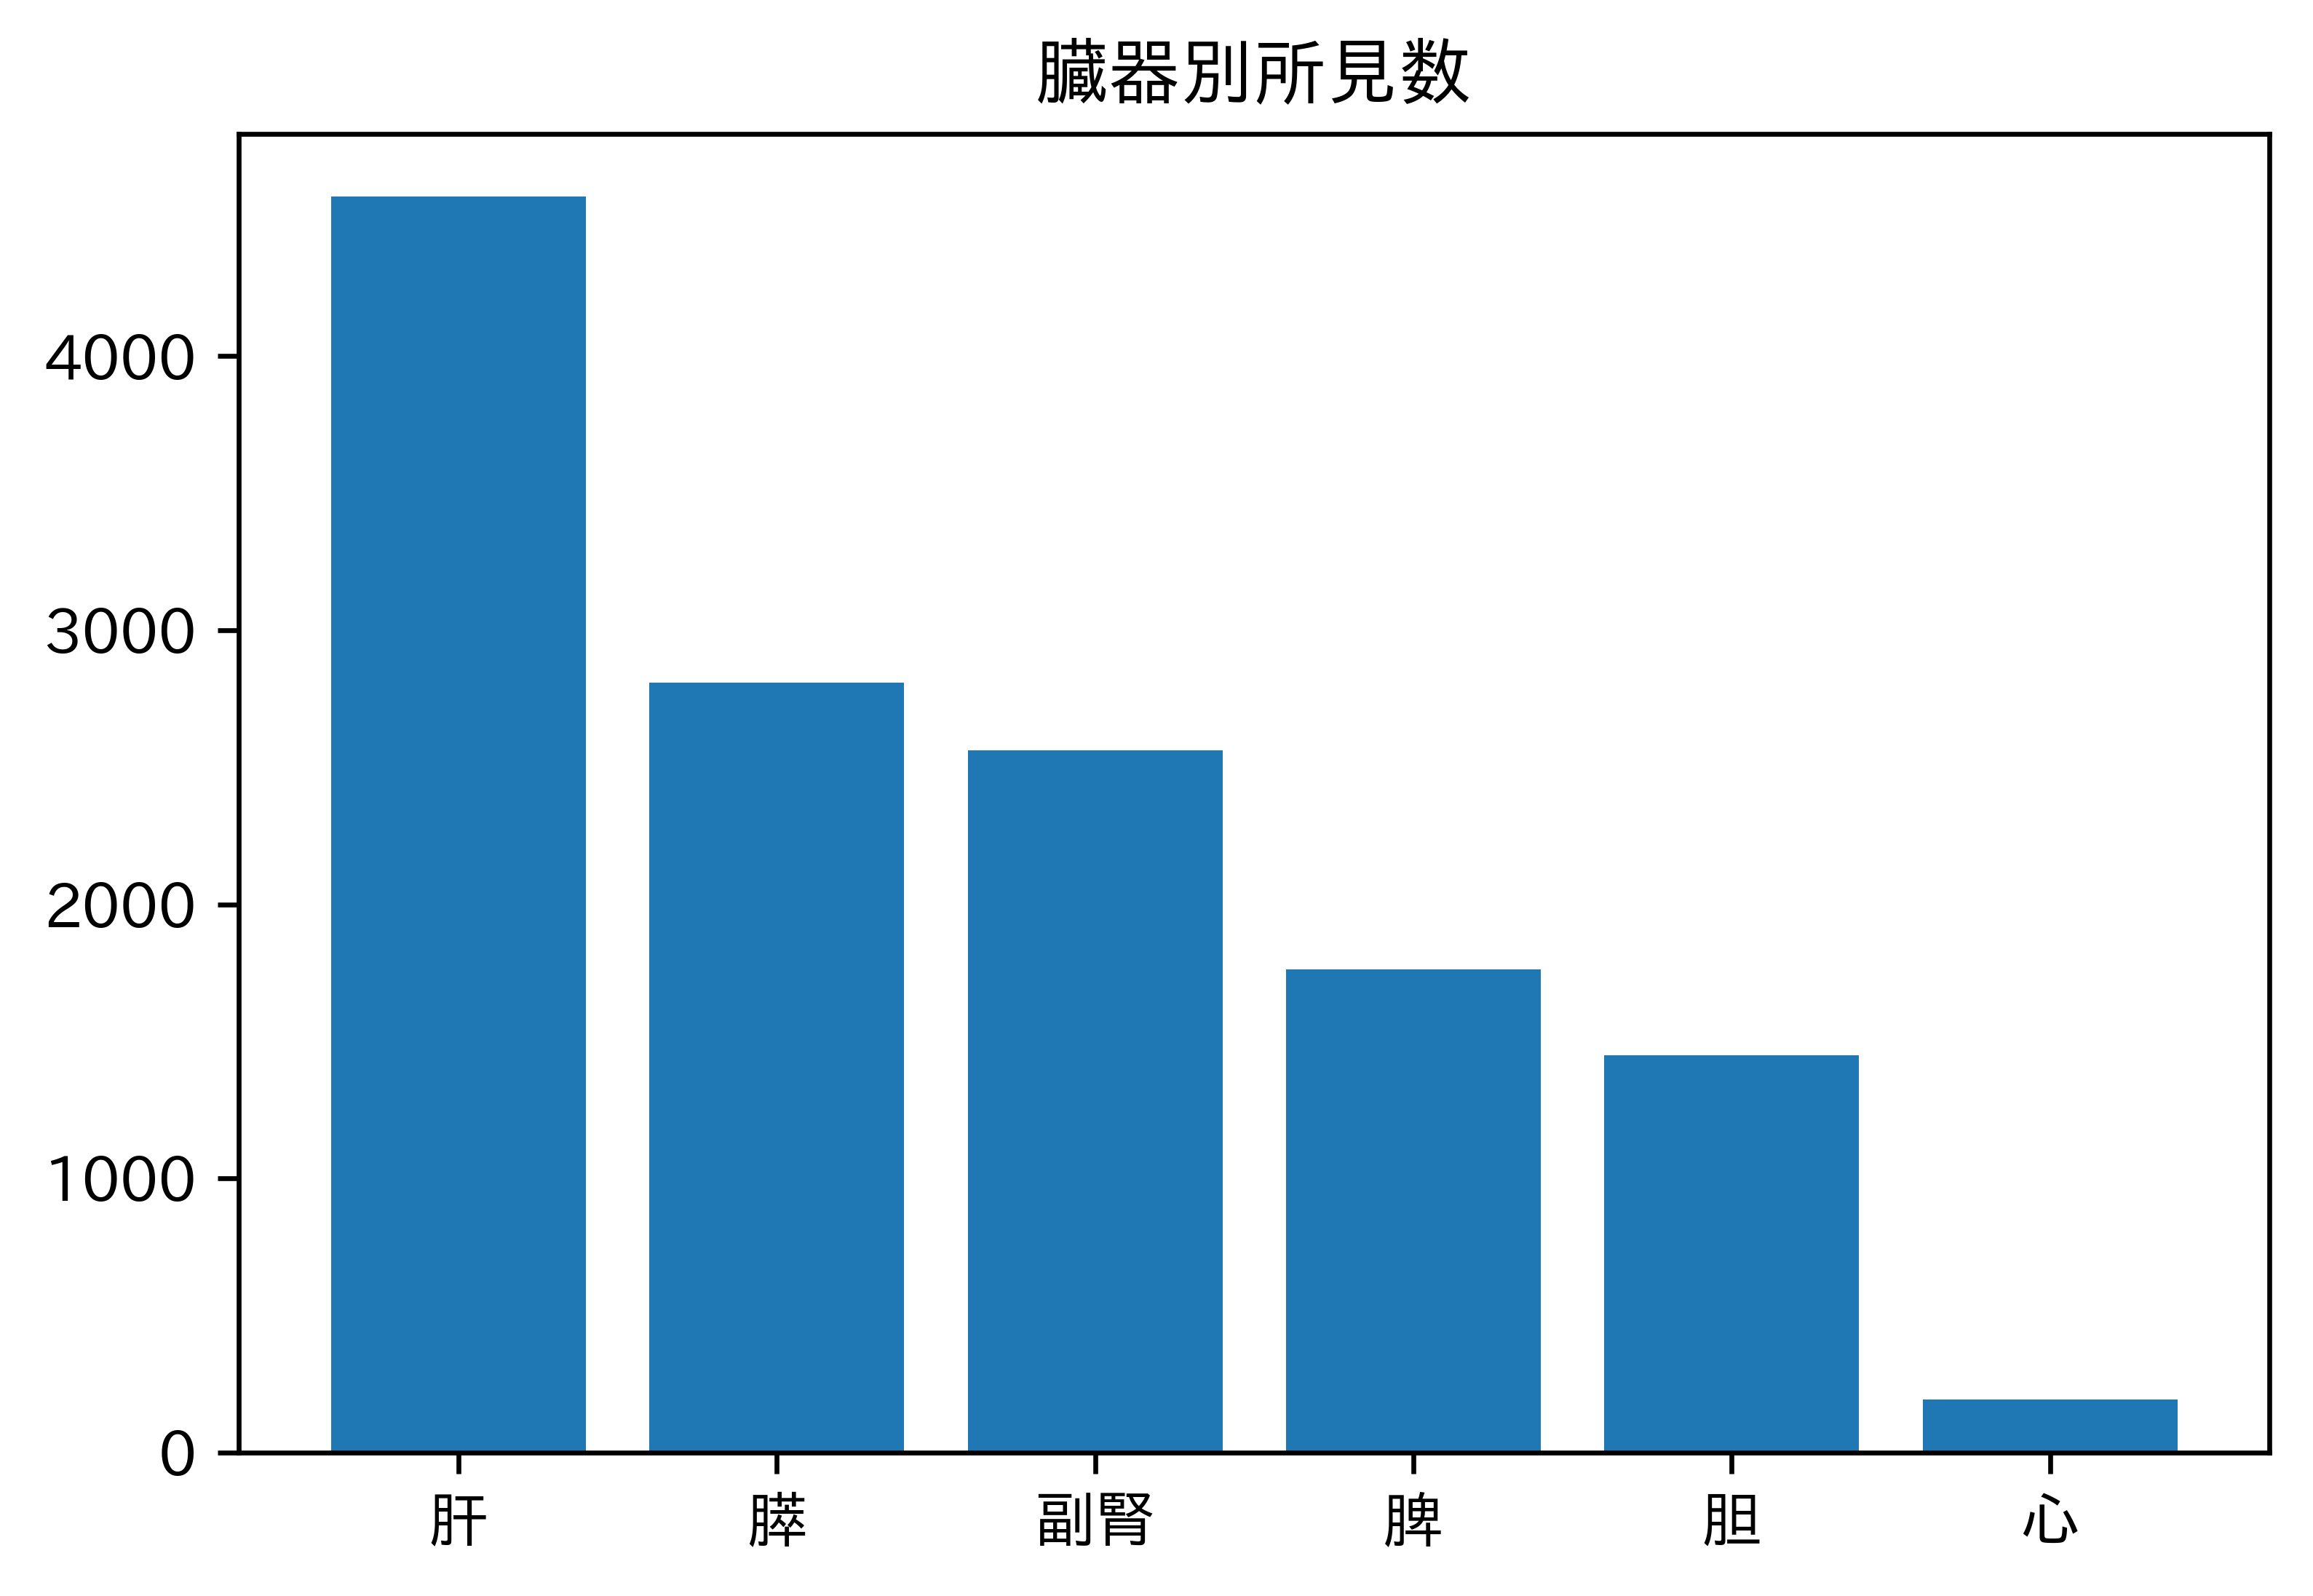

In [6]:
fig, ax = plt.subplots(1,1,dpi = 300)
ax.bar(data.organ.value_counts().index,height=data.organ.value_counts().values)
ax.set_title("臓器別所見数")

Text(0.5, 1.0, 'clinical object 所見数')

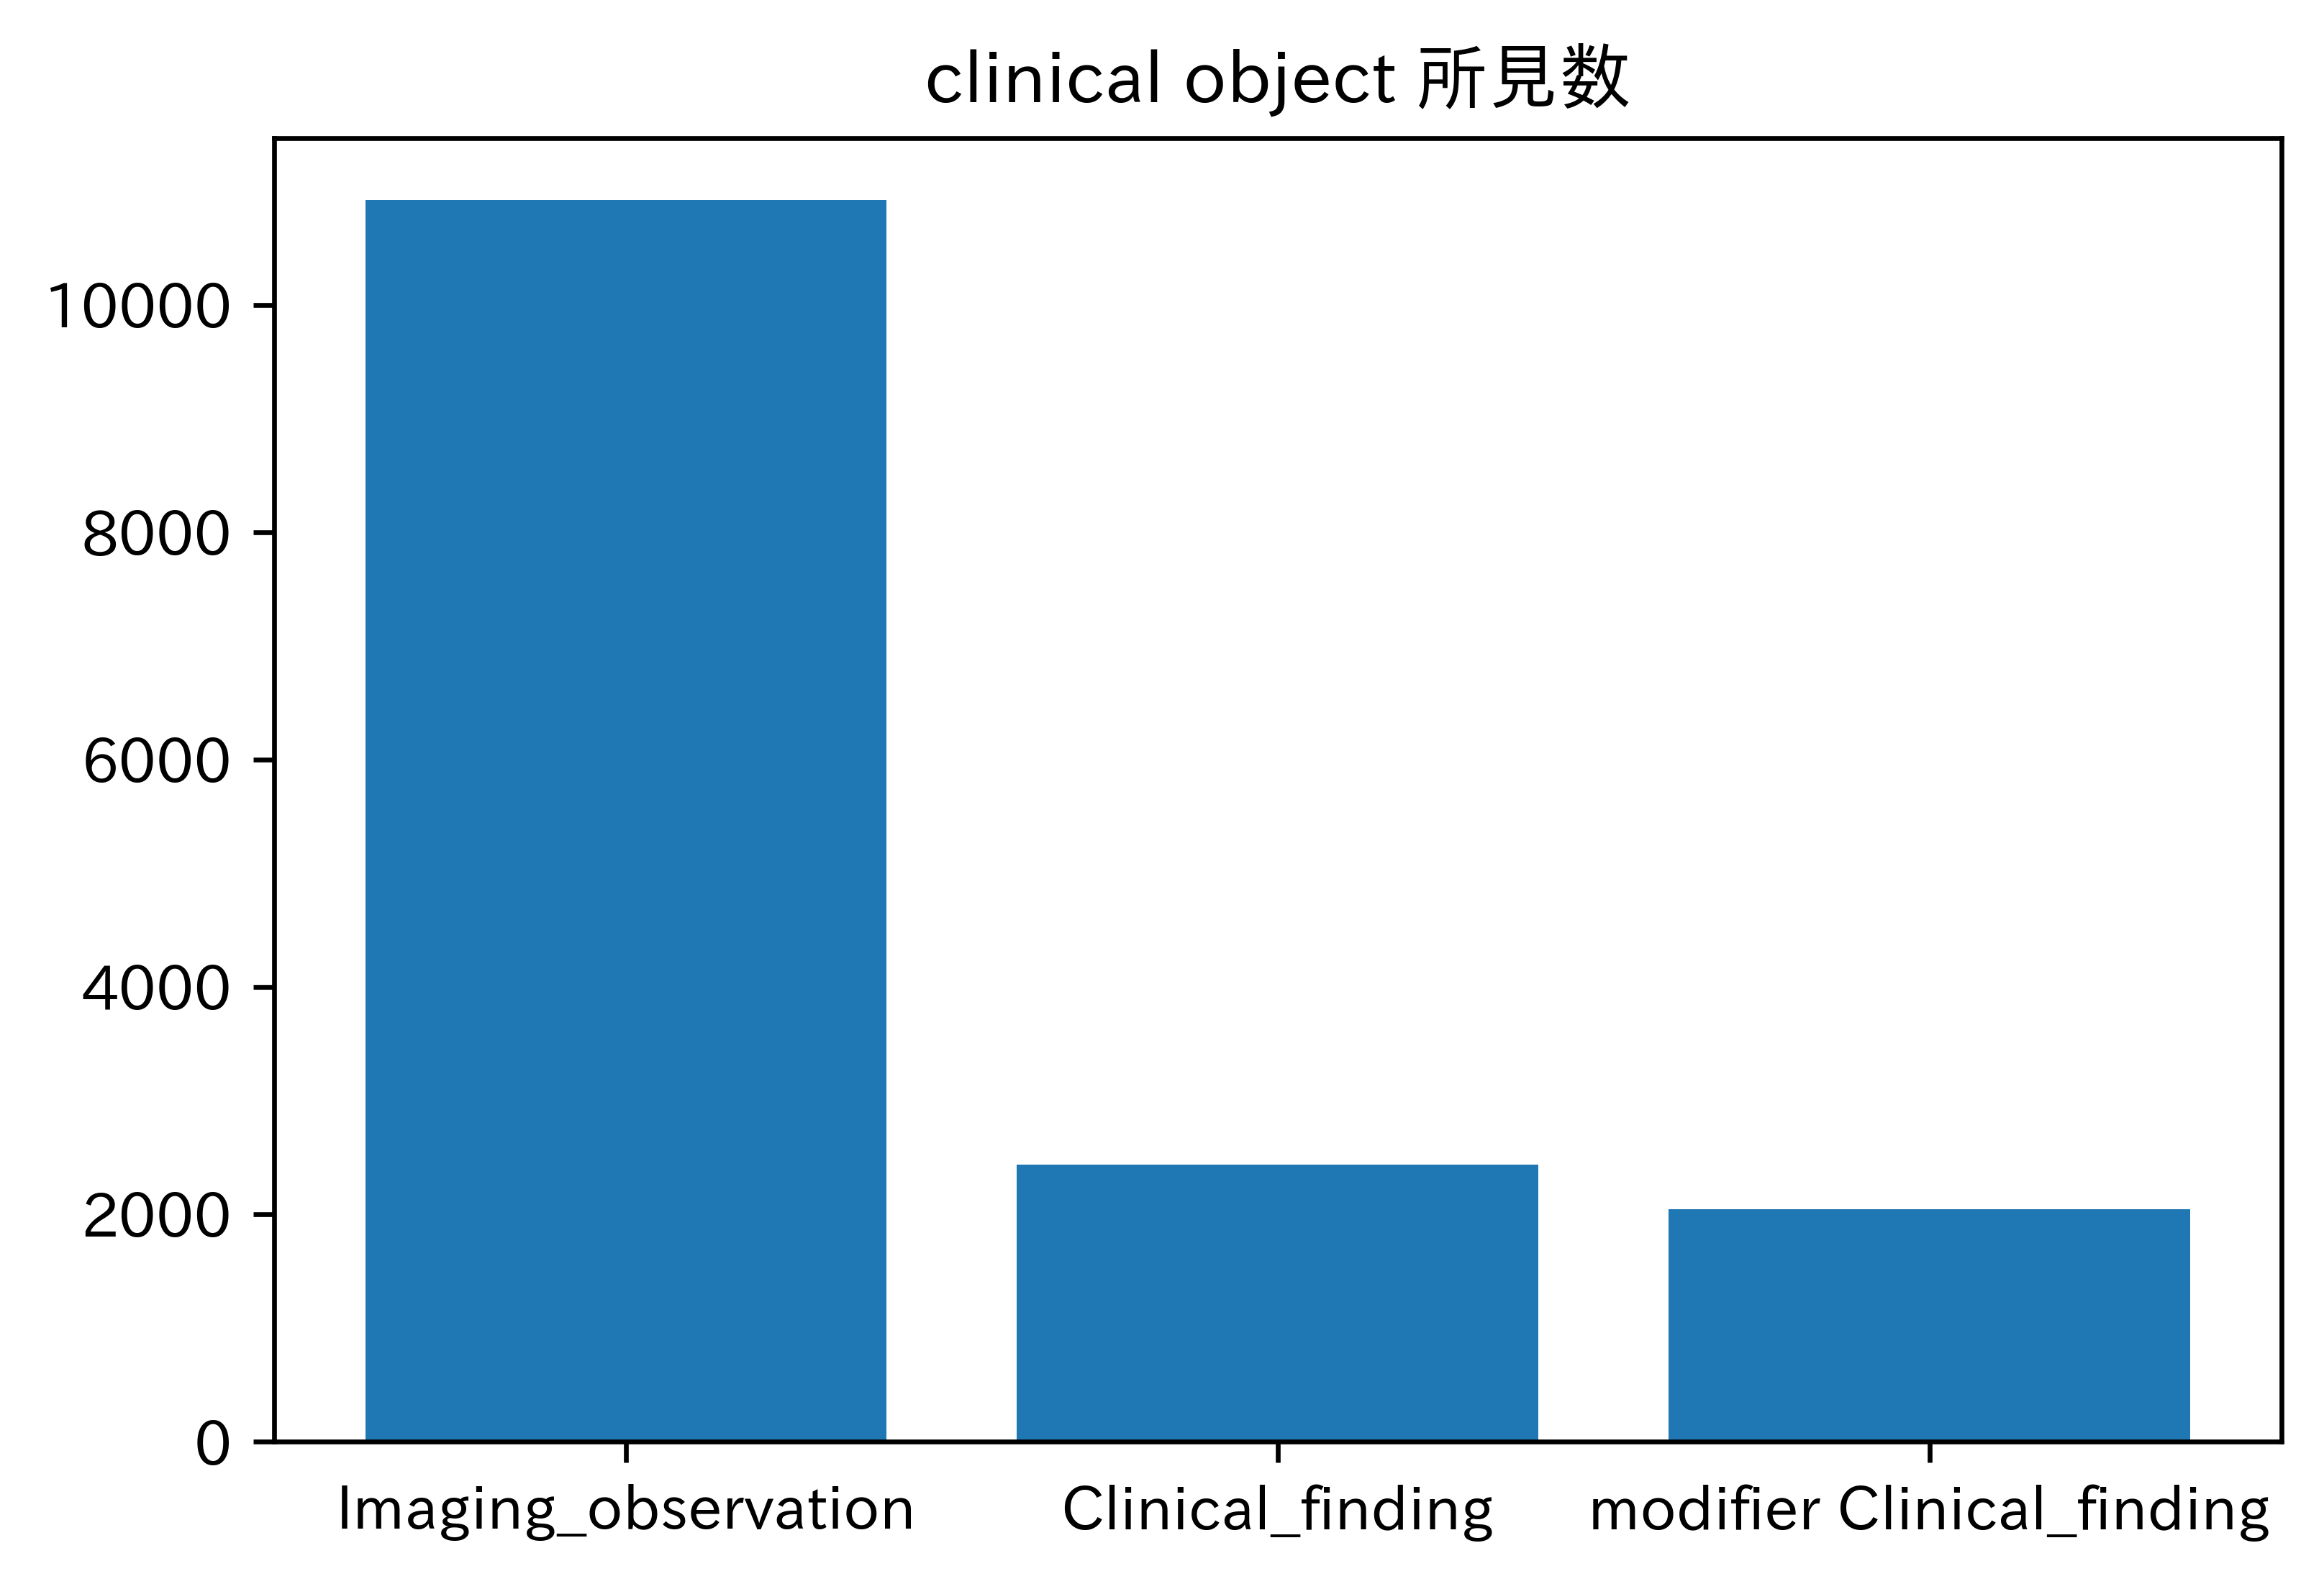

In [7]:
fig, ax = plt.subplots(1,1,dpi = 300)
index = list(data.obs_name.value_counts().index)+['modifier Clinical_finding']
values = list(data.obs_name.value_counts().values)+[data['clin_findings'].value_counts()[1:].sum()]
ax.bar(index,height=values)
ax.set_title("clinical object 所見数")

In [17]:
d[:20]

異常         624
所見         413
嚢胞性病変      142
拡張         126
嚢胞          94
異常所見        93
萎縮          90
腫瘤          81
小嚢胞         64
腫大          53
石灰化         51
IPMN        50
分枝型IPMN     41
主膵管拡張       39
慢性膵炎        26
膵癌          23
副脾          20
脂肪浸潤        18
低吸収域        17
嚢胞性腫瘤       17
Name: obs_findings, dtype: int64

In [26]:
data[data['organ'] == organ]

,file,organ,obs_findings,obs_name,obs_certainty,clin_findings,clin_certainty
11,../data/jsons_ver2/json/008268383f3e45e98df7fa...,膵,異常,Imaging_observation,0,not_found,NaN
16,../data/jsons_ver2/json/00a4a2404a234a458e469c...,膵,異常,Imaging_observation,0,not_found,NaN
24,../data/jsons_ver2/json/00c3e5ef9dad470683372f...,膵,所見,Imaging_observation,0,not_found,NaN
27,../data/jsons_ver2/json/00ceb5ac90cd4b398844e9...,膵,所見,Imaging_observation,0,not_found,NaN
35,../data/jsons_ver2/json/0112e113ac8549fb92fde9...,膵,嚢胞,Imaging_observation,4,not_found,NaN
...,...,...,...,...,...,...,...
13334,../data/jsons_ver2/json/ffbf2ffa14ba4acb8b14f4...,膵,拡張,Imaging_observation,4,not_found,NaN
13343,../data/jsons_ver2/json/ffc214976c634433b8e7cd...,膵,所見,Imaging_observation,0,not_found,NaN
13349,../data/jsons_ver2/json/ffd582221e3d486c8a6e40...,膵,所見,Imaging_observation,0,not_found,NaN
13350,../data/jsons_ver2/json/ffd582221e3d486c8a6e40...,膵,リンパ節腫大,Imaging_observation,4,反応性,4.0


異常         624
所見         413
嚢胞性病変      142
拡張         126
嚢胞          94
異常所見        93
萎縮          90
腫瘤          81
小嚢胞         64
腫大          53
石灰化         51
IPMN        50
分枝型IPMN     41
主膵管拡張       39
慢性膵炎        26
膵癌          23
副脾          20
脂肪浸潤        18
低吸収域        17
嚢胞性腫瘤       17
Name: obs_findings, dtype: int64

In [9]:
for organ in organs:
    for findings in ['Imaging_observation','Clinical_finding']:
        d = data[(data['organ'] == organ) & (data['obs_name'] == findings)]
        print(len(d))
        d = d['obs_findings'].value_counts().sort_values(ascending=False)[:20]
        #d  =pd.DataFrame(d)
        #d['label'] = d.index
        fig, ax = plt.subplots(1,1,dpi = 300)
        plt.barh(d.index[::-1], d.values[::-1])
        plt.title(f'{organ} {findings}')
        plt.savefig(f'{organ}_{findings}.png')
        plt.close()

139
54
3271
1312
1329
120
2332
478
1634
129
2215
346


In [10]:
for scale in range(5):
    for findings in ['Imaging_observation','Clinical_finding']:
        d = data[(data['obs_certainty'] == scale) & (data['obs_name'] == findings)]
        print(len(d))
        d = d['obs_findings'].value_counts().sort_values(ascending=False)[:20]
        #d  =pd.DataFrame(d)
        #d['label'] = d.index
        fig, ax = plt.subplots(1,1,dpi = 300)
        plt.barh(d.index[::-1], d.values[::-1])
        plt.title(f'certainty_scale:{str(scale)} {findings}')
        plt.savefig(f'certainty_scale:{str(scale)}_{findings}.png')
        plt.close()

6302
331
12
78
30
299
12
167
4564
1564


0    6633
1      90
2     329
3     179
4    6128
Name: obs_certainty, dtype: int64


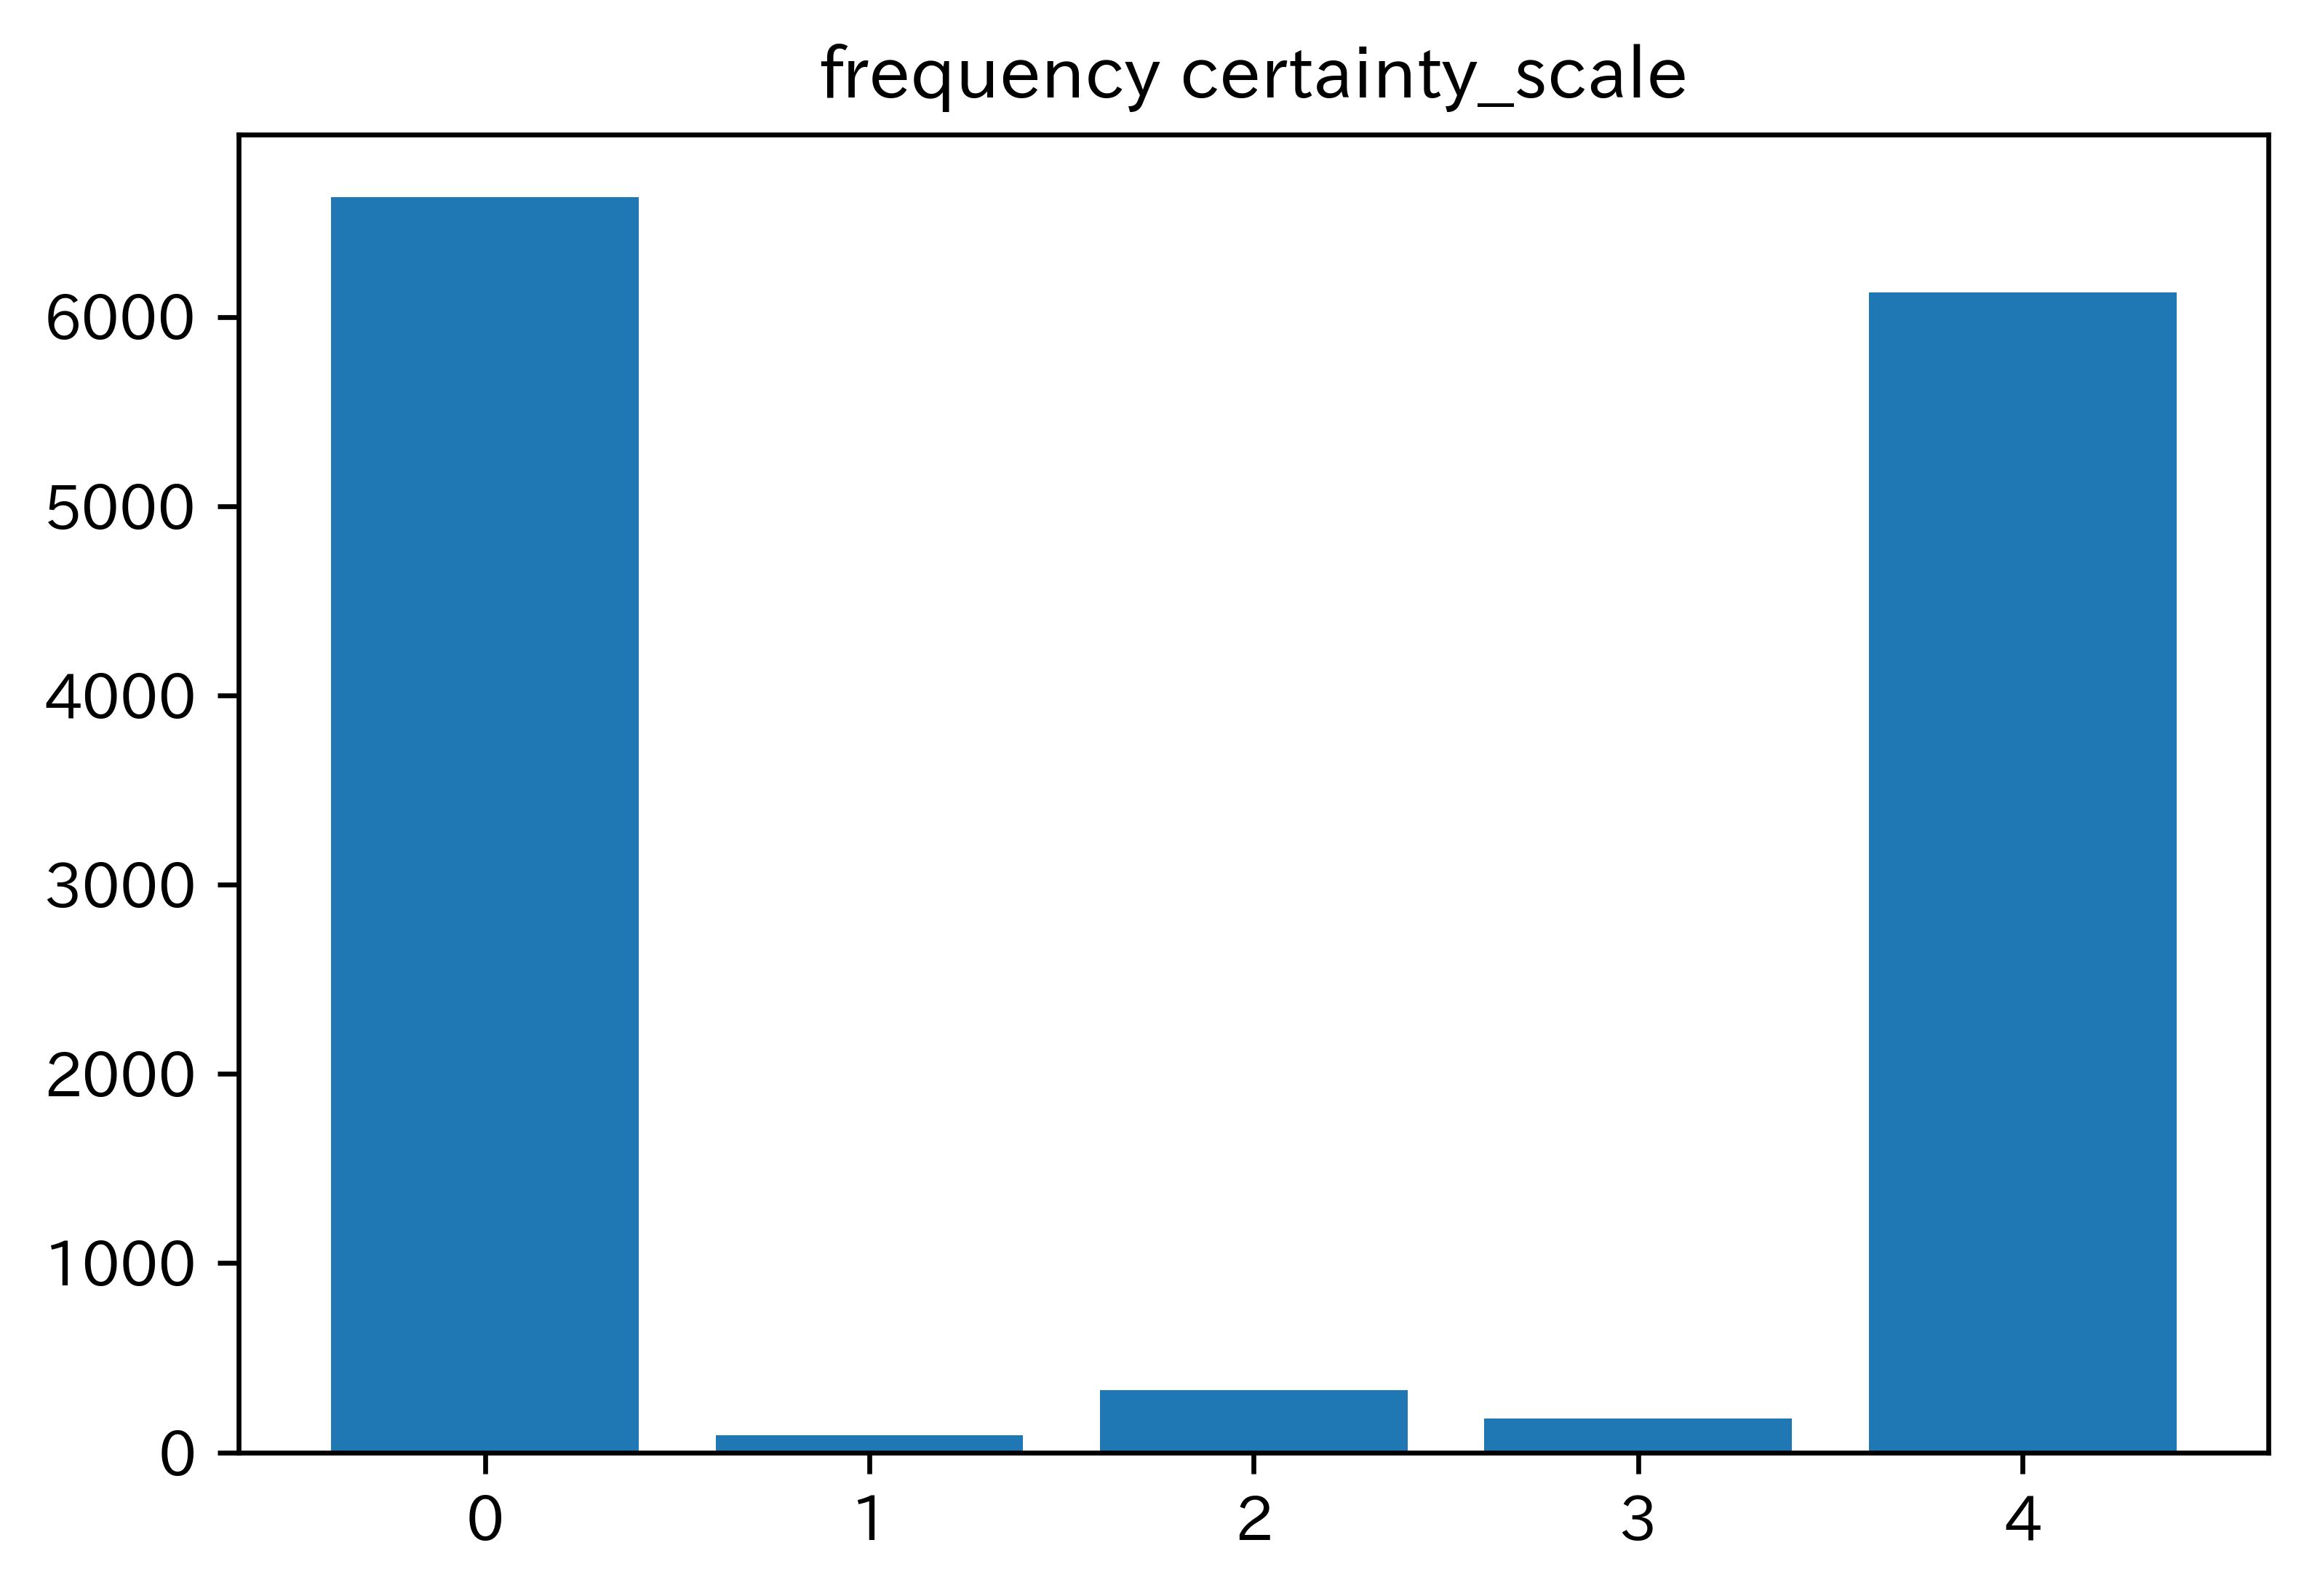

In [76]:
c = data['obs_certainty'].value_counts().sort_index(ascending=True)
print(c)
fig, ax = plt.subplots(1,1,dpi = 300)
plt.bar(c.index, c.values)
plt.title(f'frequency certainty_scale')
plt.savefig(f'freq_certainty_scale.png')
#plt.close()


<BarContainer object of 5 artists>

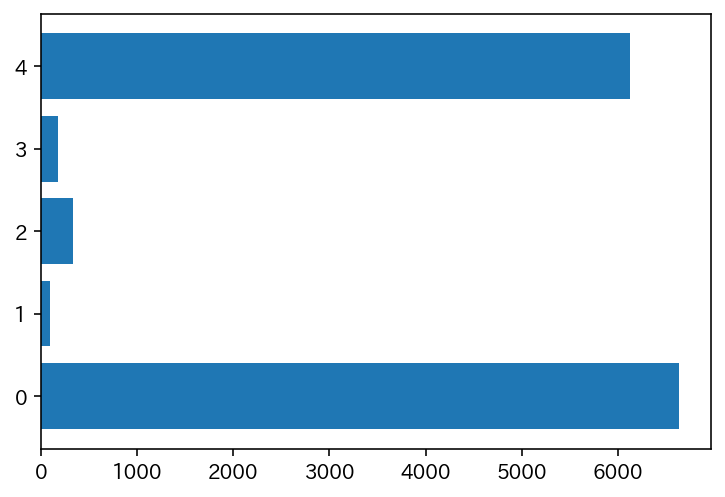

In [52]:
c = data['obs_certainty'].value_counts().sort_index()
plt.barh(c.index,c.values)

In [8]:
[ i for i in data[data['obs_certainty']==4]['obs_findings'].value_counts().index]
data

,file,organ,obs_findings,obs_name,obs_certainty,clin_findings,clin_certainty
0,../data/jsons_ver2/json/00077713ba7e48f6932db3...,胆,拡張,Imaging_observation,0,not_found,NaN
1,../data/jsons_ver2/json/00077713ba7e48f6932db3...,副腎,リンパ節腫大,Imaging_observation,0,not_found,NaN
2,../data/jsons_ver2/json/0008f9dff3a2424b860af1...,肝,血管腫,Clinical_finding,4,not_found,NaN
3,../data/jsons_ver2/json/003b19168fbc476e85803c...,副腎,腫瘤,Imaging_observation,4,腺腫,4.0
4,../data/jsons_ver2/json/003b19168fbc476e85803c...,副腎,腺腫,Clinical_finding,4,not_found,NaN
...,...,...,...,...,...,...,...
13354,../data/jsons_ver2/json/ffde076a29d642338d3591...,肝,低吸収域,Imaging_observation,4,嚢胞,4.0
13355,../data/jsons_ver2/json/ffde076a29d642338d3591...,肝,嚢胞,Clinical_finding,4,not_found,NaN
13356,../data/jsons_ver2/json/ffec85fa95164b42ac11d5...,肝,腫瘍,Clinical_finding,0,not_found,NaN
13357,../data/jsons_ver2/json/ffec85fa95164b42ac11d5...,肝,SOL,Imaging_observation,0,腫瘍,0.0


In [153]:
pd.DataFrame(change_word_list).to_csv('../output/adrenal_change_discriptor.csv',index = False)

In [17]:
json_load[0]['clinical_object']['tokens']
json_load[0]['clinical_object']['certainty_scale']

int

In [13]:
json_lists = sorted(glob.glob('../data/jsons_ver2/json/*.json'))
organs = ['膵']
#os.makedirs('../output',exist_ok=True)
counter = 0

change_word_list = []
clinical_word_list = []

for json_list in tqdm(json_lists):
    json_open = open(json_list,'r')
    key = os.path.basename(json_list).split('.')[0]
    json_load = json.load(json_open)
    for organ in organs:
        #print(organ)
        for i in range(len(json_load)):
            bool_anatomy = search_anatomy(json_load[i]['modifiers'],organ)
            
            bool_clinical,clinical = search_clinicalfinding(json_load[i]['modifiers'])
            if bool_anatomy and bool_clinical:
                clinical_word_list.append(clinical)
                print(json_load[i],json_list)
            

 28%|██▊       | 2799/9999 [00:00<00:00, 10109.34it/s]

{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['小', '結節'], 'mention': None, 'start_idx': 155, 'end_idx': 156, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵'], 'mention': None, 'start_idx': 147, 'end_idx': 147, 'sui': None, 'certainty_scale': None}, {'name': 'Anatomical_entity', 'tokens': ['脾'], 'mention': None, 'start_idx': 153, 'end_idx': 153, 'sui': None, 'certainty_scale': None}, {'name': 'Clinical_finding', 'tokens': ['血管腫'], 'mention': None, 'start_idx': 158, 'end_idx': 158, 'sui': None, 'certainty_scale': 4}]} ../data/jsons_ver2/json/01bf537fe8a947328493b947d3a8cdb0.json
{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['小', '石灰', '化'], 'mention': None, 'start_idx': 14, 'end_idx': 16, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵'], 'mention': None, 'start_idx': 12, 'end_idx': 12, 'sui': None, 'certainty_scale': None}, {'name': 'Clinical_finding', 'tokens':

 56%|█████▌    | 5585/9999 [00:00<00:00, 12342.52it/s]

{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['造影', '効果'], 'mention': None, 'start_idx': 30, 'end_idx': 31, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵'], 'mention': None, 'start_idx': 18, 'end_idx': 18, 'sui': None, 'certainty_scale': None}, {'name': 'Anatomical_entity', 'tokens': ['膵', '内', '胆', '管', '周囲'], 'mention': None, 'start_idx': 20, 'end_idx': 24, 'sui': None, 'certainty_scale': None}, {'name': 'Clinical_finding', 'tokens': ['炎症'], 'mention': None, 'start_idx': 37, 'end_idx': 37, 'sui': None, 'certainty_scale': 1}]} ../data/jsons_ver2/json/491ccf20476a4d74b24dd91987faf9aa.json
{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['所見'], 'mention': None, 'start_idx': 56, 'end_idx': 56, 'sui': None, 'certainty_scale': 0}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['胆'], 'mention': None, 'start_idx': 45, 'end_idx': 45, 'sui': None, 'certainty_scale': None}, {'name': 'Anatomical_entity', 'toke

 83%|████████▎ | 8332/9999 [00:00<00:00, 13184.17it/s]

{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['嚢胞'], 'mention': None, 'start_idx': 92, 'end_idx': 92, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵', '頚部'], 'mention': None, 'start_idx': 85, 'end_idx': 86, 'sui': None, 'certainty_scale': None}, {'name': 'Size_descriptor', 'tokens': ['１', 'cm', '強'], 'mention': None, 'start_idx': 88, 'end_idx': 90, 'sui': None, 'certainty_scale': None}, {'name': 'Clinical_finding', 'tokens': ['分', '枝', '型', 'IPMN'], 'mention': None, 'start_idx': 97, 'end_idx': 100, 'sui': None, 'certainty_scale': 3}]} ../data/jsons_ver2/json/91ccdb0347ce415f80e6b6de806b2a15.json
{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['低', '吸収', '域'], 'mention': None, 'start_idx': 151, 'end_idx': 153, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵', '尾', '部'], 'mention': None, 'start_idx': 140, 'end_idx': 142, 'sui': None, 'certainty_scale': None}, {'nam

100%|██████████| 9999/9999 [00:00<00:00, 11641.56it/s]

{'clinical_object': {'name': 'Imaging_observation', 'tokens': ['腫', '瘤'], 'mention': None, 'start_idx': 46, 'end_idx': 47, 'sui': None, 'certainty_scale': 4}, 'modifiers': [{'name': 'Anatomical_entity', 'tokens': ['膵'], 'mention': None, 'start_idx': 34, 'end_idx': 34, 'sui': None, 'certainty_scale': None}, {'name': 'Anatomical_entity', 'tokens': ['体', '部'], 'mention': None, 'start_idx': 36, 'end_idx': 37, 'sui': None, 'certainty_scale': None}, {'name': 'Size_descriptor', 'tokens': ['径', '約', '２', '．', '５', 'cm'], 'mention': None, 'start_idx': 39, 'end_idx': 44, 'sui': None, 'certainty_scale': None}, {'name': 'Change_descriptor', 'tokens': ['前回', 'と', 'ほぼ', 'サイズ', '変化', 'なし'], 'mention': None, 'start_idx': 52, 'end_idx': 57, 'sui': None, 'certainty_scale': None}, {'name': 'Clinical_finding', 'tokens': ['IPMN'], 'mention': None, 'start_idx': 59, 'end_idx': 59, 'sui': None, 'certainty_scale': 4}]} ../data/jsons_ver2/json/da4213d356794fed8fb557688e64228c.json
{'clinical_object': {'name': '

In [12]:
clinical_word_list

[]

In [21]:
clinical_word_list

['分枝型IPMN',
 '皮膚炎症',
 '分子膵管型IPMN',
 '浸潤',
 '分枝型IPMN',
 '分枝型IPMN',
 '十二指腸炎',
 '急性膵炎',
 '急性膵炎',
 '炎症波及',
 '膵炎',
 '陳旧性胸骨骨折',
 '膵炎',
 '反応性腫大',
 '膵炎',
 '慢性膵炎',
 'IPMN',
 '腹膜播種',
 'IPMN',
 '分枝型IPMN',
 '副腎腺腫',
 '副腎腺腫',
 '子宮筋腫',
 '脂肪浸潤',
 '分枝型IPMN',
 '脂肪',
 'IPMN',
 'IPMN',
 '分枝型IPMN',
 '癌',
 '混合型IPMN',
 '混合型IPMN',
 'IPMN',
 '反応性腫大',
 '胆管炎',
 '慢性膵炎',
 'IPMN',
 '分枝型IPMN',
 '仮性嚢胞',
 '膵転移',
 '分枝型IPMN',
 '嚢胞性病変',
 '膵癌',
 '嚢胞',
 '嚢胞',
 '胃粘膜下腫瘍',
 '胃粘膜下腫瘍',
 '慢性膵炎',
 '混合型IPMN',
 '混合型IPMN',
 '混合型IPMN',
 '腺筋腫症',
 '占拠性病変',
 '占拠性病変',
 '膵癌',
 '分枝型IPMN',
 'IPMN',
 '分枝型IPMN',
 '高信号',
 '高信号',
 '交通',
 '分枝膵管型IPMN',
 '分枝膵管型IPMN',
 'IPMN',
 '仮性嚢胞',
 '仮性嚢胞',
 '微小膵癌',
 '微小膵癌',
 '分枝型IPMN',
 '乏血性病変',
 '分枝膵管型IPMN',
 '拡張',
 '拡張',
 '脂肪浸潤',
 '脂肪浸潤',
 '腫瘍性病変',
 '嚢胞',
 '小腸原発濾胞性リンパ腫',
 '肝転移',
 'WON',
 '腸管炎症',
 'IPMN',
 '分枝型IPMN',
 '分枝型IPMN',
 '分枝型IPMN',
 '膵癌',
 '転移',
 '分岐型IPMN',
 '分岐型IPMN',
 '分岐型IPMN',
 'IPMN',
 'リンパ節転移',
 '分枝型IPMN',
 '筋腫',
 '腫瘍の膵管内進展',
 '腫瘍の膵管内進展',
 '腫瘍の膵管内進展',
 '線状',
 '神経叢浸潤',
 '膵癌原発巣',
 '原発巣',
 '原発巣',


In [72]:
df.to_csv('../output/sample.csv')

In [19]:
json_open = open('../json_data/response_1660614630854.json', 'r')
json_load = json.load(json_open)

In [20]:
json_load

[{'clinical_object': {'name': 'Imaging_observation',
   'tokens': ['小', '嚢胞'],
   'mention': '小嚢胞',
   'start_idx': 7,
   'end_idx': 8,
   'sui': 'OBJ002760',
   'certainty_scale': 4},
  'modifiers': [{'name': 'Anatomical_entity',
    'tokens': ['肝'],
    'mention': '肝',
    'start_idx': 0,
    'end_idx': 0,
    'sui': None,
    'certainty_scale': None},
   {'name': 'Anatomical_entity',
    'tokens': ['S', '７', '／', '８'],
    'mention': 'S７／８',
    'start_idx': 2,
    'end_idx': 5,
    'sui': None,
    'certainty_scale': None}]},
 {'clinical_object': {'name': 'Imaging_observation',
   'tokens': ['胆石'],
   'mention': '胆石',
   'start_idx': 20,
   'end_idx': 20,
   'sui': 'OBJ004923',
   'certainty_scale': 4},
  'modifiers': [{'name': 'Anatomical_entity',
    'tokens': ['胆嚢'],
    'mention': '胆嚢',
    'start_idx': 18,
    'end_idx': 18,
    'sui': None,
    'certainty_scale': None}]},
 {'clinical_object': {'name': 'Imaging_observation',
   'tokens': ['嚢胞'],
   'mention': '嚢胞',
   'start_i